<a href="https://colab.research.google.com/github/jaekyoungkim/nlp_in_action/blob/main/HAN_applied_to_mimic3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 참고 논문 : Description-based Label Attention Classifier for Explainable ICD-9 Classification
# https://git.io/JzOyk
# https://cpm0722.github.io/pytorch-implementation/transformer 
# https://hugrypiggykim.com/2018/12/09/bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding/

In [ ]:
import tensorflow as tf
import os

#resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

#tf.config.experimental_connect_to_cluster(resolver)
#tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
!pip install torchmetrics

In [ ]:
# 해당 모델을 fit 하게되면 TPU로 학습하게됨
#with strategy.scope():
#  model = create_model()
#  model.compile(optimizer='adam',
#                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                metrics=['sparse_categorical_accuracy'])

# Settings 

In [ ]:
# 구글드라이브에 핸들링한 데이터 넣어둠
# .(마침표) 남겨둔 데이터 FOR sentence 나누기
# 파일명 : notes_labeled_binarized / notes_labeled_50_binarized

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import keras
from keras import backend as K
import tensorflow as tf
#from keras.engine.topology import Layer 수정해야함
#from tensorflow.python.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Input, Embedding, Dense
from keras.layers import Lambda, Permute, RepeatVector, Multiply
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import CuDNNGRU, GRU
from keras.layers import BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import nltk

import numpy as np
import pandas as pd 
from keras.preprocessing.text import Tokenizer  # 토큰화하는 패키지
from keras.preprocessing.sequence import pad_sequences # padding 을 위한 패키지
from tensorflow.keras.utils import to_categorical #from keras.utils import to_categorical # 범주형 변수로 만들어줌 / 실행안되는 이유확인
from nltk.tokenize import sent_tokenize  # 문장을 token화 시킴
import nltk
from nltk import word_tokenize

nltk.download('punkt')
import gc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 63.4 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 880 kB 64.1 MB/s 
     |████████████████████████████████| 6.6 MB 59.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=579e36351fd117d22fb5e0f9d54cd939d4e9fac474b8cdc5c34eb8a220a72035
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 582 kB 4.3 MB/s 
     |████████████████████████████████| 408 kB 74.7 MB/s 
     |████████████████████████████████| 136 kB 31.7 MB/s 
     |████████████████████████████████| 1.1 MB 68.6 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 95.7 MB/s 
     |████████████████████████████████| 144 kB 78.7 MB/s 


In [ ]:

# long sentence 할때 이 부분 숫자를 조정해야할듯
# 데이터에서 max(sentence) 값을 적용해야할듯

MAX_SENTENCES = 150 # 10 : 몇개의 문장
MAX_SENTENCE_LENGTH = 150 # 25 :문장마다의 길이


# Dataset 

In [ ]:
# 원래 note데이터에 적용해보기
note = pd.read_csv('gdrive/MyDrive/dataset/mimic data/NOTEEVENTS.csv')
note_text = note['TEXT'] 
note_text_df = pd.DataFrame(note_text)
note_text_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,TEXT
0,Admission Date: [**2151-7-16**] Dischar...
1,Admission Date: [**2118-6-2**] Discharg...
2,Admission Date: [**2119-5-4**] D...
3,Admission Date: [**2124-7-21**] ...
4,Admission Date: [**2162-3-3**] D...
...,...
2083175,NPN\n\n\n#1 Infant remains in RA with O2 sats...
2083176,"Neonatology\nDOL #5, CGA 36 weeks.\n\nCVR: Con..."
2083177,Family Meeting Note\nFamily meeting held with ...
2083178,NPN 1800\n\n\n#1 Resp: [**Known lastname 2243*...


In [ ]:
final_data = pd.read_csv('gdrive/MyDrive/dataset/mimic data/final_data.csv')  #  encoding = 'c==p949' 생략

In [ ]:
# final_data의 text에서 각 document마다 period가 몇번 등장하는지 확인해보고자 함. period를 사용하지 않은 데이터도 있지 않을까 의심되어 확인해봄
all_text=[]
all_text = final_data['TEXT']

In [ ]:
myString = all_text[1]
print(myString.count('.'))

120


In [ ]:
print(len(all_text))
print(type(all_text))
all_text_df = pd.DataFrame(all_text)

12808
<class 'pandas.core.series.Series'>


In [ ]:
all_text[1].count('.')

120

In [ ]:
all_text_df['number_of_period']= 0
all_text_df['length']= 0
for i in range(len(all_text)):
  all_text_df['number_of_period'][i] = all_text[i].count('.')   # 12808

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
for i in range(len(all_text)):
  all_text_df['length'][i] = len(all_text[i].split())   # 12808

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
all_text_df.head(3)

,TEXT
0,admission date date of birth service cardiotho...
1,admission date date of birth service history o...
2,admission date date of birth service cardiotho...


In [ ]:
all_text_df.shape

(12808, 3)

In [ ]:
min(all_text_df['number_of_period'])  # period가 없는 문장이 존재함

0

In [ ]:
all_text_df[all_text_df['number_of_period'] ==0]  # 72개의 document에서 period가 발견되지 않음 # 해당 데이터는 제거하고 실행해야할것으로 보임 / period가 거의 안사용되는 문장들도 존재함을 알 수 있음
# 확인결과 문장자체가 짧은거였음. 굳이 해당되는 DOCUMENT 를 삭제할필요는 없음
# period 가 없는경우 length가 길지않은것을 확인할 수 있음

,TEXT,ss,number_of_period,length
194,name admission date date of birth service neur...,1,0,70
519,admission date date of birth service trauma su...,1,0,35
1048,admission date discharge date date of birth se...,1,0,15
1462,name admission date date of birth service medi...,1,0,34
1463,name admission date date of birth service medi...,1,0,34
...,...,...,...,...
11872,name admission date date of birth service medi...,1,0,26
11907,name admission date date of birth service medi...,1,0,36
12045,name admission date date of birth service card...,1,0,25
12383,name admission date date of birth service surg...,1,0,34


In [ ]:
all_text_df.iloc[11907]['TEXT']

'name admission date date of birth service medicine allergies patient recorded as having no known allergies to drugs attending addendum the attending physician for this discharge should be discharge disposition home with service facility completed by'

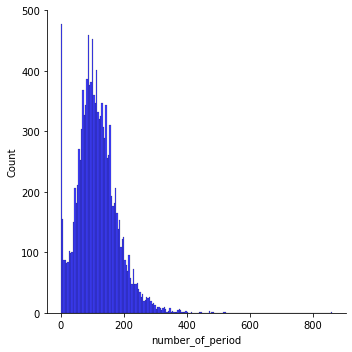

In [ ]:
sns.displot(all_text_df['number_of_period'],  bins = 200, color = "blue") 

In [ ]:
final_data.columns

Index(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID', 'TEXT', 'LABELS', '038.9',
       '244.9', '250.00', '272.0', '272.4', '276.1', '276.2', '285.1', '285.9',
       '287.5', '305.1', '311', '33.24', '36.15', '37.22', '37.23', '38.91',
       '38.93', '39.61', '39.95', '401.9', '403.90', '410.71', '412', '414.01',
       '424.0', '427.31', '428.0', '45.13', '486', '496', '507.0', '511.9',
       '518.81', '530.81', '584.9', '585.9', '599.0', '88.56', '88.72',
       '96.04', '96.6', '96.71', '96.72', '99.04', '99.15', '995.92', 'V15.82',
       'V45.81', 'V58.61'],
      dtype='object')

In [ ]:
# train / test
code = '401.9'
# y값 : top50의 하나씩 대입시킴
train_x_data = final_data['TEXT'][:10000]
train_y_data = final_data['401.9'][:10000]   # 244.9 : 갑상샘저하증  / 401.9 : hypertension
test_x_data = final_data['TEXT'][10000:]
test_y_data = final_data['401.9'][10000:] 

#train_x_data = final_data['TEXT'][:8000]
#train_y_data = final_data['244.9'][:8000]  
#test_x_data = final_data['TEXT'][8000:]
#test_y_data = final_data['244.9'][8000:]  

print("len(train_x_data): {}".format(len(train_x_data))) # 10000 / 8000
print("len(test_x_data): {}".format(len(test_x_data))) # 2808 / 4808
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)
len(tokenizer.word_index) # 63993


len(train_x_data): 10000
len(test_x_data): 2808


63993

In [ ]:
max_nb_words = len(tokenizer.word_index) + 1  # 토큰나이즈했을때에 나타나는 단어개수만큼
max_nb_words

63994

In [ ]:
train_x_data[0]

"admission date date of birth service cardiothoracic allergies bactrim ampicillin remeron attending chief complaint chest pressure cardiac tamponade cardiogenic shock major surgical or invasive procedure emergent sternotomy for pericardial window history of present illness underwent min. inv. pfo closure in on and chest pain for several days. did not resolve with pain med and had increasing sob. admitted to er for emergent eval. and bedside tte. started on dopamine drip for hypotension. past medical history s p min. inv. closure of patent foramen ovale stroke tia depression anxiety borderline hyperlipidemia herniation of cervical discs patella femoral syndrome s p bunionectomies social history denies tobacco. admits to occasional etoh. she is an employee of the children. she denies ivda and recreational drugs. family history father underwent cabg at age . cousin died of an mi at age . physical exam pt. in distress sbp 's lungs cta tachycardic rr no murmur or rubs palpable pedal pulses 

In [ ]:
sent_tokenize(train_x_data[0])

['admission date date of birth service cardiothoracic allergies bactrim ampicillin remeron attending chief complaint chest pressure cardiac tamponade cardiogenic shock major surgical or invasive procedure emergent sternotomy for pericardial window history of present illness underwent min.',
 'inv.',
 'pfo closure in on and chest pain for several days.',
 'did not resolve with pain med and had increasing sob.',
 'admitted to er for emergent eval.',
 'and bedside tte.',
 'started on dopamine drip for hypotension.',
 'past medical history s p min.',
 'inv.',
 'closure of patent foramen ovale stroke tia depression anxiety borderline hyperlipidemia herniation of cervical discs patella femoral syndrome s p bunionectomies social history denies tobacco.',
 'admits to occasional etoh.',
 'she is an employee of the children.',
 'she denies ivda and recreational drugs.',
 'family history father underwent cabg at age .',
 'cousin died of an mi at age .',
 'physical exam pt.',
 "in distress sbp 's 

In [ ]:
sent = []
word_count = []
sent_one = []
for i in range(len(train_x_data)):
  sent_one.append(sent_tokenize(train_x_data[i])) # i번째 document 기준
  sent.append(len(sent_one[i])) # 각 document마다 나다타는 문장의 수를 보여줌 
  for j in range(len(sent_one[i])):  # 각 document의 문장마다의 token개수를 word_count에 계속 추가함
    word_count.append(len(sent_one[i][j]))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

8000
452
81.0
86.5865
150.0


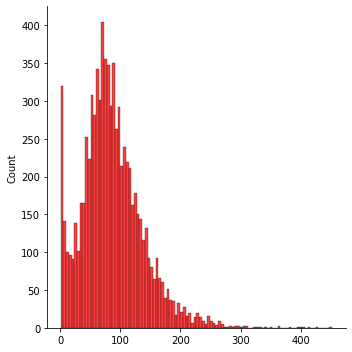

In [ ]:
print(len(sent)) # train document의 숫자
print(max(sent)) # DOCUMNET하나에서 나타나는 최대 문장개수는 452
print(np.median(sent)) # 81.0
print(np.mean(sent)) # DOCUMNET하나에서 나타나는 평균 문장개수는 86.58
print(np.quantile(sent, 0.9)) # 150
sns.displot(sent,  bins = 100, color = "red")  # 200아래에서 거의 존재함

In [ ]:
print(len(sent_one))
print(len(word_count))  # 전체 document의 문장의수는 692692
print(np.mean(word_count)) #문장마다의 평균 토큰수는 80.5
print(max(word_count)) #문장에서 나타나는 최대 토큰수는 2323
print(np.quantile(word_count, 0.9)) # 90quantile : 167.0

8000
692692
80.58640636819828
2323
167.0


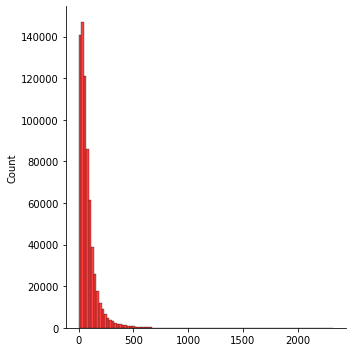

In [ ]:
sns.displot(word_count,  bins = 100, color = "red")  # 거의 대부분이 200이하임을 알 수 있음

[287,
 4,
 50,
 53,
 33,
 16,
 41,
 29,
 4,
 191,
 26,
 35,
 39,
 45,
 29,
 17,
 111,
 6,
 5,
 13,
 3,
 220,
 42,
 101,
 34,
 78,
 31,
 36,
 76,
 61,
 73,
 24,
 70,
 23,
 38,
 35,
 16,
 32,
 11,
 68,
 23,
 84,
 23,
 59,
 23,
 68,
 23,
 35,
 28,
 178,
 455,
 247,
 37,
 55,
 89,
 40,
 13,
 10,
 29,
 13,
 18,
 24,
 25,
 13,
 12,
 14,
 12,
 14,
 16,
 15,
 46,
 6,
 85,
 44,
 47,
 29,
 10,
 12,
 12,
 19,
 39,
 59,
 27,
 22,
 87,
 65,
 71,
 29,
 12,
 33,
 28,
 9,
 99,
 54,
 144,
 57,
 83,
 136,
 26,
 53,
 42,
 63,
 40,
 26,
 164,
 37,
 16,
 12,
 28,
 15,
 17,
 19,
 21,
 16,
 21,
 254,
 44,
 80,
 165,
 28,
 256,
 131,
 151,
 82,
 87,
 72,
 107,
 363,
 41,
 40,
 183,
 126,
 125,
 240,
 113,
 178,
 121,
 171,
 151,
 135,
 107,
 95,
 24,
 23,
 13,
 25,
 27,
 25,
 14,
 36,
 28,
 23,
 17,
 19,
 21,
 21,
 6,
 91,
 93,
 38,
 76,
 54,
 117,
 125,
 28,
 473,
 22,
 59,
 95,
 42,
 69,
 59,
 24,
 40,
 66,
 47,
 28,
 62,
 25,
 51,
 19,
 48,
 50,
 47,
 11,
 22,
 37,
 51,
 24,
 127,
 31,
 188,
 160,
 109,
 1

In [ ]:
print(sent_one) 

['admission date date of birth service cardiothoracic allergies no known allergies adverse drug reactions attending chief complaint chest pain major surgical or invasive procedure procedures .', 'third time redo sternotomy.second time aortic valve replacement with a mm onyx mechanical valve reference number number .', 'redo cabg times with reverse saphenous vein graft from the neo ascending aorta to the preexisting saphenous vein graft to the right coronary artery reverse saphenous vein graft from the neo ascending aorta to the preexisting om vein graft.endoscopic vein harvesting.replacement of ascending aorta with a mm tube graft using deep hypothermic circulatory arrest .', 'sternal re exploration removal of packing and sternal closure history of present illness mr. with month of worsening cp on exertion and doe.', 'approximately month ago mr. doe which have been worsening over the last weeks.', 'approximately week ago he also noted resting shoulder pain and nocturnal cough.', 'pain 

In [ ]:
np.mean(word_count) # 80.58640636819828

80.58640636819828

In [ ]:
len(word_count) # 총문장의 개수는 692692

692692

In [ ]:
word_token = tokenizer.texts_to_sequences(sent_one)
len(word_token[2])

56

In [ ]:
print(word_token[0])
print(len(word_token[0]))

[40, 61, 61, 3, 206, 100, 1029, 130, 12, 279, 130, 1407, 460, 1409, 237, 259, 247, 63, 41, 244, 139, 18, 239, 136, 2416]
25


In [ ]:
len(word_token)

114

In [ ]:
sent_one

['admission date date of birth service cardiothoracic allergies no known allergies adverse drug reactions attending chief complaint chest pain major surgical or invasive procedure procedures .',
 'third time redo sternotomy.second time aortic valve replacement with a mm onyx mechanical valve reference number number .',
 'redo cabg times with reverse saphenous vein graft from the neo ascending aorta to the preexisting saphenous vein graft to the right coronary artery reverse saphenous vein graft from the neo ascending aorta to the preexisting om vein graft.endoscopic vein harvesting.replacement of ascending aorta with a mm tube graft using deep hypothermic circulatory arrest .',
 'sternal re exploration removal of packing and sternal closure history of present illness mr. with month of worsening cp on exertion and doe.',
 'approximately month ago mr. doe which have been worsening over the last weeks.',
 'approximately week ago he also noted resting shoulder pain and nocturnal cough.',
 

In [ ]:
print(type(sent))
sent_df = pd.DataFrame(sent)
sent_df.shape #(8000, 1) 
sent_df

<class 'list'>


,0
0,51
1,69
2,45
3,45
4,153
...,...
7995,93
7996,69
7997,118
7998,155


In [ ]:
print(max(sent)) # 452 : 각 document 1개 안에 있는 문장의 개수
print(np.mean(sent)) # 90.2226 : 평균적인 길이
print(min(sent)) # 1
print(len(sent))

452
86.5865
1
8000


원본 : "Admission Date:  [**2135-5-9**]              Discharge Date:   [**2135-5-13**]

Date of Birth:  [**2087-7-14**]             Sex:   F

Service: CARDIOTHORACIC

Allergies:
Bactrim / Ampicillin / Remeron

Attending:[**First Name3 (LF) 1283**]
Chief Complaint:
chest pressure/cardiac tamponade/ cardiogenic shock

Major Surgical or Invasive Procedure:
emergent sternotomy for pericardial window  [**2135-5-9**]


History of Present Illness:
Underwent min. inv. PFO closure in [**12-11**]. Had emergent admission
on [**5-9**] for hypotension, pericardial effusion , pleural effusion
and chest pain for several days. Did not resolve with pain med
and had increasing SOB. Admitted to ER for emergent eval. and
bedside TTE. Started on dopamine drip for hypotension.

Past Medical History:
s/p min. inv. closure of Patent foramen ovale [**12-11**]; History of
Stroke/TIA; Depression; Anxiety; Borderline Hyperlipidemia;
Herniation of Cervical Discs; Patella-Femoral Syndrome; s/p
Bunionectomies

Social History:
Denies tobacco. Admits to occasional ETOH. She is an employee of
the [**Hospital1 18**] in the Neuro-Pysch Department. She is married with two
children. She denies IVDA and recreational drugs.


Family History:
Father underwent CABG at age 72. Cousin died of an MI at age 46.

Physical Exam:
pt. in distress
SBP 70- 80's
lungs CTA
tachycardic, RR, no murmur or rubs
palpable pedal pulses

Pertinent Results:
[**2135-5-11**] 08:40AM BLOOD WBC-11.3* RBC-3.62* Hgb-9.9* Hct-28.8*
MCV-80* MCH-27.3 MCHC-34.3 RDW-14.4 Plt Ct-413
[**2135-5-9**] 11:45AM BLOOD Neuts-86.5* Lymphs-7.0* Monos-5.2 Eos-1.2
Baso-0.2
[**2135-5-11**] 08:40AM BLOOD Plt Ct-413
[**2135-5-11**] 08:40AM BLOOD Glucose-118* UreaN-8 Creat-0.6 Na-136
K-3.7 Cl-102 HCO3-24 AnGap-14
[**2135-5-9**] 11:45AM BLOOD CK(CPK)-26
[**2135-5-9**] 11:45AM BLOOD CK-MB-NotDone cTropnT-<0.01

Brief Hospital Course:
Admitted through ER as above and referred to CT [**Doctor First Name **] for
emergent pericardial window/pericardectomy via sternotomy, as
the patient was hypotensive.This was performed by Dr. [**Last Name (STitle) 1290**]
on [**5-9**]. Transferred to CSRU in stable condition on phenylephrine
and propofol drips. Extubated and awoke neurologically intact.
Beta blockade started on POD #1 and transferred out to the floor
to start increasing her activity level. Mediastinal tubes
removed on POD #1. Crepitus was noted on anterior chest wall
after pleural tubes removed on POD #2. Beta blockade also
titrated up. Crepitus improved and CXR confirmed. She made good
progress and was discharged to home with VNA services on POD #4.

Medications on Admission:
ASA 325 mg daily


Discharge Medications:
1. Docusate Sodium 100 mg Capsule Sig: One (1) Capsule PO BID (2
times a day) for 1 months.
Disp:*60 Capsule(s)* Refills:*0*
2. Ranitidine HCl 150 mg Tablet Sig: One (1) Tablet PO BID (2
times a day) for 1 months.
Disp:*60 Tablet(s)* Refills:*0*
3. Aspirin 81 mg Tablet, Delayed Release (E.C.) Sig: One (1)
Tablet, Delayed Release (E.C.) PO DAILY (Daily).
Disp:*30 Tablet, Delayed Release (E.C.)(s)* Refills:*2*
4. Acetaminophen 325 mg Tablet Sig: Two (2) Tablet PO Q4H (every
4 hours) as needed.
Disp:*30 Tablet(s)* Refills:*0*
5. Oxycodone-Acetaminophen 5-325 mg Tablet Sig: 1-2 Tablets PO
Q4H (every 4 hours) as needed for pain.
Disp:*40 Tablet(s)* Refills:*0*
6. Furosemide 20 mg Tablet Sig: One (1) Tablet PO once a day for
3 days.
Disp:*3 Tablet(s)* Refills:*0*
7. Potassium Chloride 20 mEq Packet Sig: One (1) Packet PO once
a day for 3 days.
Disp:*3 Packet(s)* Refills:*0*
8. Metoprolol Tartrate 25 mg Tablet Sig: 1.5 Tablets PO BID (2
times a day).
Disp:*90 Tablet(s)* Refills:*1*


Discharge Disposition:
Home With Service

Facility:
[**Company 1519**]

Discharge Diagnosis:
s/p emergent pericardial window via sternotomy [**2135-5-9**]
cardiogenic shock/tamponade
s/p Min inv. PFO closure [**12-11**]
s/p CVA
anxiety/depression
cervical disc herniation
patella-femoral syndrome
borderline hyperlipidemia


Discharge Condition:
stable


Discharge Instructions:
may shower over incision and gently pat dry
no lotions, creams or powders on incision
no driving for one month
no lifting greater than 10 pounds for 10 weeks
call for fever greater than 100, redness or drainage

Followup Instructions:
follow up with Dr. [**Last Name (STitle) **] (PCP) in [**2-7**] weeks
follow up with Dr. [**Last Name (STitle) **] (Card)in [**3-11**] weeks
follow up with Dr. [**Last Name (STitle) 1290**] in 4 weeks   [**Telephone/Fax (1) 170**]



Completed by:[**2135-5-13**]"

In [ ]:
def doc2hierarchical(text,
                     max_sentences=MAX_SENTENCES,  # 위에서 정의한값
                     max_sentence_length=MAX_SENTENCE_LENGTH):  # 위에서 정의한값
    sentences = sent_tokenize(text)  # 긴문장을 문장 단위로 쪼개줌
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)  # setence 를 tokenizing
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length)  # 패딩을 써서 길이를 맞춰춤

    pad_size = max_sentences - tokenized_sentences.shape[0]

    if pad_size <= 0:  # tokenized_sentences.shape[0] < max_sentences
        tokenized_sentences = tokenized_sentences[:max_sentences]  # 패딩사이즈를 넘어가면 중간에 잘라주어야함
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )

    return tokenized_sentences


def build_dataset(x_data, y_data,
                  max_sentences=MAX_SENTENCES,
                  max_sentence_length=MAX_SENTENCE_LENGTH,
                  tokenizer=tokenizer):
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)

        X_data[i] = tokenized_sentences[None, ...]

    nb_classes = len(set(y_data))  # 0,1 : 2개 카테고리 > 2값이 나옴
    Y_data = to_categorical(y_data, nb_classes)  # 1/0 binary를 2개의 컬럼으로 나타냄 / one-hot encoding과 같음
    # Y_data = y_data
    return X_data, Y_data

In [ ]:
len(set(train_y_data))

2

In [ ]:
train_X_data, train_Y_data = build_dataset(train_x_data, train_y_data)
test_X_data, test_Y_data = build_dataset(test_x_data, test_y_data)

#train_X_data[1][1]
#train_X_data[1]

print("train_X_data.shape: {}".format(train_X_data.shape)) # (10000, 300, 30)
print("test_X_data.shape: {}".format(test_X_data.shape)) # 
print("train_Y_data.shape: {}".format(train_Y_data.shape)) # (10000, 300, 30)
print("test_Y_data.shape: {}".format(test_Y_data.shape)) # 

train_X_data.shape: (10000, 150, 150)
test_X_data.shape: (2808, 150, 150)
train_Y_data.shape: (10000, 2)
test_Y_data.shape: (2808, 2)


In [ ]:
train_Y_data

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
train_X_data[1].shape

(150, 150)

In [ ]:
train_X_data

array([[[   0,    0,    0, ...,  162,  347, 1313],
        [   0,    0,    0, ...,    0,    0, 6701],
        [   0,    0,    0, ...,   11,  367,   84],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[   0,    0,    0, ...,    1, 6702,  649],
        [   0,    0,    0, ...,   29,  640,   48],
        [   0,    0,    0, ...,  619,  272,   69],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[   0,    0,    0, ...,    9,   88,   70],
        [   0,    0,    0, ...,    4,   56,   48],
        [   0,    0,    0, ..., 2091,  867,   90],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       ...,

       [[   0,    0,    

In [ ]:
train_Y_data[1].shape

(2,)

In [ ]:
train_Y_data.shape # (800, 50, 50)

(1000, 2)

In [ ]:
train_X_data[1]

array([[   0,    0,    0, ...,    1, 6702,  649],
       [   0,    0,    0, ...,   29,  640,   48],
       [   0,    0,    0, ...,  619,  272,   69],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [ ]:
len(train_X_data[1][2])

150

In [ ]:
# train-valid test split (9:1)
from sklearn.model_selection import train_test_split
# train -> train과 valid로 나누기
train_X_data, val_X_data, train_Y_data, val_Y_data = train_test_split(train_X_data, train_Y_data, test_size=0.1,random_state=42)
print("train_X_data.shape: {}".format(train_X_data.shape))
print("train_Y_data.shape: {}".format(train_Y_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("val_Y_data.shape: {}".format(val_Y_data.shape))


train_X_data.shape: (9000, 150, 150)
train_Y_data.shape: (9000, 2)
val_X_data.shape: (1000, 150, 150)
val_Y_data.shape: (1000, 2)


# word2vec embedding 

In [ ]:
# google이 이미 word2vec의 결과로 각 word에 대한 vector를 만들어서 배포
# 하지만 용량이 커서 작은 용량에서는 어렵죠. 그래서 작은 용량의 word2vec vector로 존재
# vector를 특정 분야에 맞게 특화시키킬 원할 경우,
# Word2vec.intersect_word2vec_format(googleNews_filepath, binary=True, lockf=1.0)을 통해 쉽게 초기값을 설정
# word2vec-GoogleNews-vectors에서 이미 학습된 word2vector를 다운가능
# 다만, 학습된 모델을 가져오는 것이 아니라, “학습된 vector”만을 수치로 가져오는 것이죠.
# 다운로드 받아놓은게 있어서 따로 다운받을 필요 없을듯
#import gensim.downloader as api
#wv = api.load('word2vec-google-news-300')
#vec_king = wv['king']

#embedding_dir = '/home/kjk88/TBM_DBLAC', # 파일 넣은 위치

# word2vec을 가져옴
def load_word2vec(tokenizer=tokenizer):
    from gensim.models import KeyedVectors
    embedding_path = '/content/gdrive/MyDrive/dataset/word2vec/GoogleNews-vectors-negative300.bin'  # embedding_dir 위치에 다운로드 받은 파일을 넣기 다운받는데 시간이 좀 걸림
    # embedding_path = os.path.join(embedding_dir,'GoogleNews-vectors-negative300.bin')
    # https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz 해당링크에서 파일 다운로드 1.5GB정도됨
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)

    return embeddings_index  # embedding_index 를 불러옴, 예를들면 dog라는 단어가 있으면 dog의  index 500 을 가져옴



In [ ]:

def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()  # 위에서 언급한 함수가 사용됨 load_word2vec

    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix
    # dog라른 단어가 있으면 해당 index를 구하고 해당 index를 찾아서 이에 대한 벡터를 가져옴
    # 전체 사용한 단어에 대해서 이에 대한 벡터 매트릭스를 생성해줌
    # 여기서는 124253단어에 대해서 해당 벡터를 전부 가져올 수 있음

embedding_matrix = load_embedding('word2vec')

print("embedding_matrix.shape: {}".format(embedding_matrix.shape)) # (652, 300)
embedding_matrix # 총 63994 개의 단어들을 각각 300차원으로 만들어서 표현함
embedding_matrix.shape #(63994, 300)

embedding_matrix.shape: (63994, 300)


(63994, 300)

In [ ]:
embedding_matrix

array([[-0.02571043,  0.04594054,  1.28959919, ...,  1.69539948,
        -0.22164818, -0.51038252],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [ 1.16676737, -0.14165325, -0.41545953, ..., -0.35986965,
        -0.67138298, -0.56746426],
       ...,
       [ 1.0342072 , -0.16165226, -0.06095427, ..., -1.53094361,
         0.73069171,  0.18755734],
       [-0.71425425,  0.96896899, -0.06801718, ...,  0.20618149,
        -0.29593339,  0.08899368],
       [ 0.09648669, -0.95898575,  1.38542459, ..., -0.80097238,
         1.81907782,  1.48624783]])

# evaluation metrics 

In [ ]:
# evaluation function 3가지
def recall(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1))  # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))  # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # TP = y_target_yn * y_pred_yn
    # FN = y_target_yn - (y_target_yn * y_pred_yn)

    # return a single tensor value
    return recall

def precision(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))  # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1))  # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # FP = y_pred_yn - (y_target_yn * y_pred_yn)

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = (2 * _recall * _precision) / (_recall + _precision + K.epsilon())

    # return a single tensor value
    return _f1score


# layers setting

In [ ]:
class AttentionLayer(Layer):  # Layer를 가져옴
    def __init__(self, attention_dim, **kwargs):  # **kwargs : list가져올때 씀
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)  # attentionlayer의 속성을 가져옴

    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',  # attention 값 이값을 확인해야하는것 같음
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)  # 학습가능
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim,),  # attention값과 쌍을 이룸?
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',  # u: context vector
                                 shape=(self.attention_dim, 1),  # attention값과 쌍을 이룸?
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)  # hiddenlayer와의 계산
        a_it = K.dot(u_it, self.u)  # a가 attention을 의미함 word attention이라고 볼 수 있음
        a_it = K.squeeze(a_it, -1)  # 일자형태로 만들기
        a_it = K.softmax(a_it)  # softmax함수 적용 합이1이 되게함

        return a_it

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])


def WeightedSum(attentions, representations):  #
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation  # 합쳐진 representation


In [ ]:
def HieAtt(embedding_matrix,  # word2vec한 값
           max_sentences,
           max_sentence_length,
           nb_classes,  # 클래스의 개수 여기서는 2개
           embedding_dim=300,  # 임베딩 차원 여기서는 300차원으로 변환시킴
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    # Use tf.keras.optimizers.Adam(learning_rate) instead of keras.optimizers.Adam(learning_rate)

    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1  # 124253-1
    embedding_layer = Embedding(max_nb_words + 1,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,  # input
                                trainable=False)  # embedding한걸 다시 학습할 필요없음

    # first, build a sentence encoder
    sentence_input = Input(shape=(max_sentence_length,), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)  # sentence에 대한 임베딩 / sentence단위의 임베딩으로 한단계 위
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
    contextualized_sentence = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_sentence)  # CuDNNGRU
    # embedded sentence 를 bidirectional featrue2개가 생성되고 두개가 합쳐짐

    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)  # 위에서 설정한 attentionlayer함수사용
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)  # 위에서 설정한 weightedsum 함수사용

    sentence_encoder = Model(inputs=[sentence_input],  # from keras.models import Model,
                             outputs=[sentence_representation])  # sentence를 벡터로 표현하는 과정

    # then, build a document encoder (최종 아웃풋임)
    document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
    embedded_document = TimeDistributed(sentence_encoder)(document_input)
    contextualized_document = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_document)  # CuDNNGRU
    # sentence를 이용해서 doc에 대한 representation v계산

    # sentence attention computation
    sentence_attention = AttentionLayer(attention_dim)(contextualized_document)
    # 해당 코드에서 가장 중요한 부분 : sentence_attention  각 sentence별 attention값이 계산되는것을 확인
    document_representation = WeightedSum(sentence_attention, contextualized_document)
    # doc에 대해 하나로 표현가능한 vector값이 나오게됨

    # 마지막 fc layer를 통해서 분류문제를 해결하고자 함
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):  # 클래스 수만큼 fc layer를 수행함
        if include_dense_batch_normalization == True:  # batch norm 을 한경우
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:  # drop_out 을 한경우
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))  # soft max

    pred_sentiment = fc_layers(document_representation)  # 최종 결과값이라 볼 수 있음

    model = Model(inputs=[document_input],
                  outputs=[pred_sentiment])

    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input],
                                     outputs=[word_attention])
    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
    attention_extractor = Model(inputs=[document_input],
                                outputs=[word_attentions, sentence_attention])
    # 모델에 대한 마지막 정의
    model.compile(loss=['categorical_crossentropy'],
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model, attention_extractor, sentence_attention, word_attentions

# model - HAN 

In [ ]:
model_name = "HieAtt"
model_path = '/content/checkpoints/{}.h5'.format(model_name)
checkpointer = ModelCheckpoint(filepath=model_path,
                               monitor='val_acc',
                               verbose=True,
                               save_best_only=True,
                               mode='max')

In [ ]:
model, attention_extractor, sentence_att, word_att = HieAtt(embedding_matrix=embedding_matrix,
                                    max_sentences=MAX_SENTENCES,
                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                    nb_classes=2,
                                    embedding_dim=300,
                                    attention_dim=100,
                                    rnn_dim=150,
                                    include_dense_batch_normalization=False,
                                    include_dense_dropout=True,
                                    nb_dense=1,
                                    dense_dim=300,
                                    dense_dropout=0.2,
                                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
                                    )


model.summary()  # OUTPUT SHAPE를 확인 가능


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150)]   0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 150, 300)    19635200    ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 150, 300)    406800      ['time_distributed[0][0]']       
 )                                                                                                
                                                                                            

In [ ]:
validation_data=(val_X_data, val_Y_data) ;type(validation_data) # TUPLE

tuple

In [ ]:
train_X_data.shape # (720, 300, 50)

(9000, 150, 150)

In [ ]:
print(val_Y_data.shape)  # (80, 2)


(1000, 2)


In [ ]:
# 실제 데이터에 적용하는 과정
# Hyperparameter
max_sentences = 150
max_sentence_length = 150  # maxlen이랑 같음
# 사전에서 단어 수(embedding layer에서 사용)
max_nb_words = len(tokenizer.word_index) + 1
max_nb_words # 63994
early_stop = EarlyStopping(monitor='val_loss', patience=10)
gc.collect()

37334

In [ ]:
history = model.fit(x=train_X_data,  # x : list
                    y=train_Y_data,  # y: list
                    batch_size= 32, # 128
                    epochs=15,  # 100
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data)  # tuple , 'NoneType' object is not callable
                    ,callbacks=[early_stop]
                    )


# error
# def _fixup_shape(images, labels):
#    images.set_shape([None, 15, 256, 256, 3])
#    labels.set_shape([None, 12])
#    return images, labels
# as_list() is not defined on an unknown tensorshape

#model.load_weights(model_path)
# Epoch 7/15
# 282/282 [==============================] - 2104s 7s/step - loss: 0.3510 - accuracy: 0.8510 - val_loss: 0.4962 - val_accuracy: 0.7930

Epoch 1/15
282/282 [==============================] - 2096s 7s/step - loss: 0.6681 - accuracy: 0.6057 - val_loss: 0.5793 - val_accuracy: 0.6880
Epoch 2/15
282/282 [==============================] - 2084s 7s/step - loss: 0.5197 - accuracy: 0.7393 - val_loss: 0.4704 - val_accuracy: 0.7580
Epoch 3/15
282/282 [==============================] - 2090s 7s/step - loss: 0.4521 - accuracy: 0.7943 - val_loss: 0.4893 - val_accuracy: 0.7770
Epoch 4/15
282/282 [==============================] - 2093s 7s/step - loss: 0.4212 - accuracy: 0.8171 - val_loss: 0.4491 - val_accuracy: 0.7940
Epoch 5/15
282/282 [==============================] - 2094s 7s/step - loss: 0.3889 - accuracy: 0.8331 - val_loss: 0.4608 - val_accuracy: 0.7940
Epoch 6/15
282/282 [==============================] - 2102s 7s/step - loss: 0.3763 - accuracy: 0.8397 - val_loss: 0.4696 - val_accuracy: 0.7910
Epoch 7/15
282/282 [==============================] - 2104s 7s/step - loss: 0.3510 - accuracy: 0.8510 - val_loss: 0.4962 - val_accuracy:

In [ ]:
# 모델 전체 저장하기 / 총 50개의 모델에 대해서 저장함
import torch as th
# Pytorch 모델 파일은 확장자가 pt

path = 'gdrive/MyDrive/dataset/mimic data/'
th.save(model,path+code)

INFO:tensorflow:Assets written to: ram://10bfff4a-f638-444b-aba7-3a3567364419/assets


INFO:tensorflow:Assets written to: ram://10bfff4a-f638-444b-aba7-3a3567364419/assets


In [ ]:
# Pytorch에서 모델의 state_dict은 학습가능한 매개변수가 담겨있는 딕셔너리(Dictionary)
th.save(model.state_dict(), 'model.pt')

In [ ]:
# 모델 불러오기 / torch.load(path)
model = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

#checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
#model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer'])

Test Accuracy of HieAtt: 0.7824074029922485


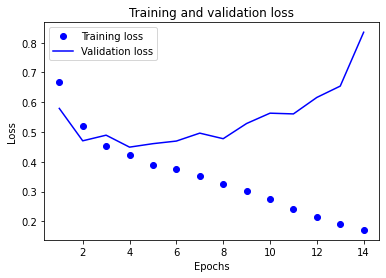

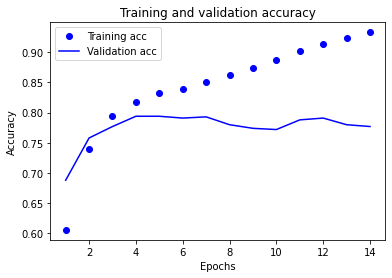

In [ ]:
# 성능 시각화하기
score = model.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=50)
print("Test Accuracy of {}: {}".format(model_name, score[1])) # Test Accuracy of HieAtt: 0.6171652674674988

import matplotlib.pyplot as plt
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

# model- HAN (y:top50 code)

In [ ]:
# y값이 50개의 컬럼들이 다 들어가게됨, train / test
train_x_data = final_data['TEXT'][:800]
train_y_data = final_data[['038.9','244.9', '250.00', '272.0', '272.4', '276.1', '276.2', '285.1', '285.9', '287.5', '305.1',
                           '311', '33.24', '36.15', '37.22', '37.23', '38.91','38.93', '39.61', '39.95', '401.9', '403.90',
                           '410.71', '412', '414.01','424.0', '427.31', '428.0', '45.13', '486', '496', '507.0', '511.9',
                           '518.81', '530.81', '584.9', '585.9', '599.0', '88.56', '88.72', '96.04', '96.6', '96.71', '96.72',
                           '99.04', '99.15', '995.92', 'V15.82', 'V45.81', 'V58.61']][:800]
test_x_data = final_data['TEXT'][800:1000]
test_y_data = final_data[['038.9','244.9', '250.00', '272.0', '272.4', '276.1', '276.2', '285.1', '285.9', '287.5', '305.1', '311', '33.24', '36.15', '37.22', '37.23', '38.91','38.93', '39.61', '39.95', '401.9', '403.90', '410.71', '412', '414.01','424.0', '427.31', '428.0', '45.13', '486', '496', '507.0', '511.9', '518.81', '530.81', '584.9', '585.9', '599.0', '88.56', '88.72', '96.04', '96.6', '96.71', '96.72', '99.04', '99.15', '995.92', 'V15.82', 'V45.81', 'V58.61']][800:1000]

print("len(train_x_data): {}".format(len(train_x_data))) # 10000 / 8000
print("len(test_x_data): {}".format(len(test_x_data))) # 
print("len(train_y_data): {}".format(len(train_y_data))) # 
print("len(test_y_data): {}".format(len(test_y_data))) #
print("train_x_data shape: {}".format(train_x_data.shape)) # 10000 / 8000
print("train_y_data shape: {}".format(train_y_data.shape)) #

len(train_x_data): 800
len(test_x_data): 200
len(train_y_data): 800
len(test_y_data): 200
train_x_data shape: (800,)
train_y_data shape: (800, 50)


In [ ]:
import numpy as np
import torch as th
from sklearn.metrics import roc_curve, auc
import torchmetrics

#######################################################################################
# METRICS PACKAGE: This file contains metrics for multi-label classification evaluation
#######################################################################################

########################################
# PREPARE: Prepare outputs for evaluation metrics
########################################

def prepare_outputs(logits, target_labels):
    """
    Transform logits into one-hot-encoded vector for classification metric computation
    Parameters
    ----------
    logits : tensor (batch_size x target_label_classes)
        predicted logits outputed by classifier for every label class
    target_labels : tensor (batch_size x target_label_classes)
        ground truth of class labels

    Returns
    -------
    y_pred: tensor (batch_size x target_label_classes) as float
        transformed predicted logits in one-hot-encoded vector
    y_true : tensor (batch_size x target_label_classes) as int
        ground truth of class labels
    """
    #y_pred = (th.sigmoid(logits) > 0.5).float()
    y_pred = (th.sigmoid(logits)).float()
    y_true = target_labels.int()
    assert y_true.shape == y_pred.shape, "y_pred must be same shape as y_true"
    return y_pred, y_true

def prepare_outputs_caml(logits, target_labels):
    y_pred = (th.sigmoid(logits) > 0.5).int().cpu().detach().numpy()
    y_pred_raw = (th.sigmoid(logits)).float().cpu().detach().numpy()
    y_true = target_labels.int().cpu().detach().numpy()
    y_true_mic = y_true.ravel()
    y_pred_mic = y_pred.ravel()
    assert y_true.shape == y_pred.shape == y_pred_raw.shape, "y_pred must be same shape as y_true"
    assert len(y_true_mic) == len(y_pred_mic), "y_pred must be same shape as y_true"
    return y_pred, y_pred_raw, y_true, y_true_mic, y_pred_mic

def prepare_outputs_inference(logits, target_labels):
    """
    Transform logits into one-hot-encoded vector for classification metric computation
    Parameters
    ----------
    logits : tensor (batch_size x target_label_classes)
        predicted logits outputed by classifier for every label class
    target_labels : tensor (batch_size x target_label_classes)
        ground truth of class labels

    Returns
    -------
    y_pred: tensor (batch_size x target_label_classes) as float
        transformed predicted logits in one-hot-encoded vector
    y_true : tensor (batch_size x target_label_classes) as float
        ground truth of class labels
    """
    y_pred = (th.sigmoid(logits) > 0.5).int()
    y_true = target_labels.int()
    assert y_true.shape == y_pred.shape, "y_pred must be same shape as y_true"
    return y_pred, y_true

###############################################################################################
# CAML: micro- and macro metrics as implemented by caml- paper for sanity checking torchmetrics
###############################################################################################
"""
Inputs:
yhat: binary predictions matrix 
yhat_raw: prediction scores matrix (floats)
y: binary ground truth matrix
y_mic: raveled y matrix (np.ravel())
k: for @k metrics

Outputs:
dict holding relevant metrics
"""

def union_size(yhat, y, axis):
    #axis=0 for label-level union (macro). axis=1 for instance-level
    return np.logical_or(yhat, y).sum(axis=axis).astype(float)

def intersect_size(yhat, y, axis):
    #axis=0 for label-level union (macro). axis=1 for instance-level
    return np.logical_and(yhat, y).sum(axis=axis).astype(float)

# MACRO metrics
def macro_accuracy(yhat, y):
    num = intersect_size(yhat, y, 0) / (union_size(yhat, y, 0) + 1e-10)
    return np.mean(num)

def macro_precision(yhat, y):
    num = intersect_size(yhat, y, 0) / (yhat.sum(axis=0) + 1e-10)
    return np.mean(num)

def macro_recall(yhat, y):
    num = intersect_size(yhat, y, 0) / (y.sum(axis=0) + 1e-10)
    return np.mean(num)

def macro_f1(yhat, y):
    prec = macro_precision(yhat, y)
    rec = macro_recall(yhat, y)
    if prec + rec == 0:
        f1 = 0.
    else:
        f1 = 2*(prec*rec)/(prec+rec)
    return f1

# MICRO metrics
def micro_accuracy(yhatmic, ymic):
    return intersect_size(yhatmic, ymic, 0) / union_size(yhatmic, ymic, 0)

def micro_precision(yhatmic, ymic):
    return intersect_size(yhatmic, ymic, 0) / yhatmic.sum(axis=0)

def micro_recall(yhatmic, ymic):
    return intersect_size(yhatmic, ymic, 0) / ymic.sum(axis=0)

def micro_f1(yhatmic, ymic):
    prec = micro_precision(yhatmic, ymic)
    rec = micro_recall(yhatmic, ymic)
    if prec + rec == 0:
        f1 = 0.
    else:
        f1 = 2*(prec*rec)/(prec+rec)
    return f1

#AUC metrics
def auc_metrics(yhat_raw, y, ymic):
    if yhat_raw.shape[0] <= 1:
        return
    fpr = {}
    tpr = {}
    roc_auc = {}
    #get AUC for each label individually
    relevant_labels = []
    auc_labels = {}
    for i in range(y.shape[1]):
        #only if there are true positives for this label
        if y[:,i].sum() > 0:
            fpr[i], tpr[i], _ = roc_curve(y[:,i], yhat_raw[:,i], pos_label=1)
            if len(fpr[i]) > 1 and len(tpr[i]) > 1:
                auc_score = auc(fpr[i], tpr[i])
                if not np.isnan(auc_score):
                    auc_labels["auc_%d" % i] = auc_score
                    relevant_labels.append(i)
    #macro-AUC: just average the auc scores
    aucs = []
    for i in relevant_labels:
        aucs.append(auc_labels['auc_%d' % i])
    roc_auc['auc_macro'] = np.mean(aucs)

    #micro-AUC: just look at each individual prediction
    yhatmic = yhat_raw.ravel()
    fpr["micro"], tpr["micro"], _ = roc_curve(ymic, yhatmic)
    roc_auc["auc_micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc

def precision_at_k(yhat_raw, y, k):
    '''
    This metric equals to torchmetrics.Precision(num_classes=num_classes, threshold=0.5, average='macro', top_k=5)
    '''
    #num true labels in top k predictions / k
    sortd = np.argsort(yhat_raw)[:,::-1]
    topk = sortd[:,:k]
    #get precision at k for each example
    vals = []
    for i, tk in enumerate(topk):
        if len(tk) > 0:
            num_true_in_top_k = y[i,tk].sum()
            denom = len(tk)
            vals.append(num_true_in_top_k / float(denom))
    return np.mean(vals)

#######################################################################
#COMPUTE ALL METRICS: all metrics needed for evaluation are calculated
#######################################################################

def all_metrics(y_pred, y_true, logits,  num_labels, top_k):
    print('Computing all metrics...')
    device = th.device('cuda' if th.cuda.is_available() else 'cpu')
    # move tensors if necessary
    y_pred.to(device), y_pred.to(device), logits.to(device)
    # Instantiate all metrics
    accuracy = torchmetrics.Accuracy().to(device)
    accuracy_subset = torchmetrics.Accuracy(subset_accuracy=True).to(device)
    precision_macro = torchmetrics.Precision(num_classes=num_labels, threshold=0.5, average='macro').to(device)
    precision_micro = torchmetrics.Precision(threshold=0.5, average='micro').to(device)
    precision_macro_topk = torchmetrics.Precision(num_classes=num_labels, threshold=0.5, average='macro', top_k=top_k).to(device)
    precision_micro_topk = torchmetrics.Precision(threshold=0.5, average='micro', top_k=5).to(device)
    recall_macro = torchmetrics.Recall(num_classes=num_labels, threshold=0.5, average='macro').to(device)
    recall_micro = torchmetrics.Recall(threshold=0.5, average='micro').to(device)
    f_1_macro = torchmetrics.classification.F1(num_classes=num_labels, threshold=0.5, average='macro').to(device)
    f_1_micro = torchmetrics.classification.F1(num_classes=num_labels, threshold=0.5, average='micro').to(device)

    # Compute all metrics
    accuracy = accuracy(y_pred, y_true)
    accuracy_subset = accuracy_subset(y_pred, y_true)
    precision_macro = precision_macro(y_pred, y_true)
    precision_micro = precision_micro(y_pred, y_true)
    precision_macro_topk = precision_macro_topk(y_pred, y_true)
    precision_micro_topk = precision_micro_topk(y_pred, y_true)
    recall_macro = recall_macro(y_pred, y_true)
    recall_micro = recall_micro(y_pred, y_true)
    f_1_macro = f_1_macro(y_pred, y_true)
    f_1_micro = f_1_micro(y_pred, y_true)

    # Compute auc-scroes as in CAML paper (and other caml metrics for sanity checking torchmetrics)
    y_pred_caml, y_pred_raw_caml, y_true_caml, y_true_mic_caml, y_pred_mic_caml = prepare_outputs_caml(logits, y_true)
    f_1_macro_caml = macro_f1(y_pred_caml, y_true_caml)
    f_1_micro_caml = micro_f1(y_pred_mic_caml, y_true_mic_caml)
    auc = auc_metrics(y_pred_raw_caml, y_true_caml, y_true_mic_caml)


    all_metrics = {'accuracy': accuracy, 'accuracy_subset': accuracy_subset,'precision_macro': precision_macro, 'precision_micro': precision_micro, 'precision_macro_topk': precision_macro_topk,
                   'precision_micro_topk': precision_micro_topk, 'recall_macro': recall_macro, 'recall_micro': recall_micro, 'f_1_macro': f_1_macro, 'f_1_macro_caml': f_1_macro_caml, 'f_1_micro': f_1_micro, 'f_1_micro_caml':f_1_micro_caml}
    all_metrics.update(auc)
    return all_metrics


In [ ]:
a=to_categorical(train_y_data,2)
print(a.shape)
b=a.reshape((800,100))
print(b.shape)
# y1개일때 (800,2) -> y50개일때 (800,100)
print(len(b))

(800, 50, 2)
(800, 100)
800


In [ ]:
#Y_data = to_categorical(train_y_data, 2)  # 1/0 binary를 2개의 컬럼으로 나타냄 / one-hot encoding과 같음
#Y_data = Y_data.reshape((len(Y_data)),100)
#Y_data = Y_data.reshape((len(Y_data)),100)

#print(type(Y_data))
#print(type(train_y_data))
#print(Y_data.shape)
#print(Y_data)
#print(np.array(train_y_data))
#print(train_y_data.shape)

In [ ]:
def build_dataset50(x_data, y_data,
                  max_sentences=MAX_SENTENCES,
                  max_sentence_length=MAX_SENTENCE_LENGTH,
                  tokenizer=tokenizer):
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)

        X_data[i] = tokenized_sentences[None, ...]

    nb_classes = 50  # 50개의 컬럼에 대해서 각각에 0,1값이 들어가게됨 (multilabel)
    Y_data = np.array(y_data)
    # Y_data = to_categorical(y_data, 2)  # 1/0 binary를 2개의 컬럼으로 나타냄 / one-hot encoding과 같음
    # Y_data = Y_data.reshape((len(Y_data)),100)
    
    return X_data, Y_data


In [ ]:
train_X_data, train_Y_data = build_dataset50(train_x_data, train_y_data)
test_X_data, test_Y_data = build_dataset50(test_x_data, test_y_data)

train_X_data[1][1]
train_X_data[1]

print("train_X_data.shape: {}".format(train_X_data.shape)) # (10000, 300, 30)
print("test_X_data.shape: {}".format(test_X_data.shape)) # 
print("train_Y_data.shape: {}".format(train_Y_data.shape)) # (10000, 300, 30)
print("test_Y_data.shape: {}".format(test_Y_data.shape)) # 

train_X_data.shape: (800, 150, 150)
test_X_data.shape: (200, 150, 150)
train_Y_data.shape: (800, 50)
test_Y_data.shape: (200, 50)


In [ ]:
# train-valid test split (9:1)
from sklearn.model_selection import train_test_split
# train -> train과 valid로 나누기
train_X_data_50, val_X_data_50, train_Y_data_50, val_Y_data_50 = train_test_split(train_X_data, train_Y_data, test_size=0.1,random_state=42)
print("train_X_data.shape: {}".format(train_X_data_50.shape))
print("train_Y_data.shape: {}".format(train_Y_data_50.shape))
print("val_X_data.shape: {}".format(val_X_data_50.shape))
print("val_Y_data.shape: {}".format(val_Y_data_50.shape))

validation_data=(val_X_data_50, val_Y_data_50) ;type(validation_data) # TUPLE

train_X_data.shape: (720, 150, 150)
train_Y_data.shape: (720, 50)
val_X_data.shape: (80, 150, 150)
val_Y_data.shape: (80, 50)


tuple

In [ ]:
# evaluation function 3가지 for top50
def recall(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1))  # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))  # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # TP = y_target_yn * y_pred_yn
    # FN = y_target_yn - (y_target_yn * y_pred_yn)

    # return a single tensor value
    return recall

def precision(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))  # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1))  # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # FP = y_pred_yn - (y_target_yn * y_pred_yn)

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = (2 * _recall * _precision) / (_recall + _precision + K.epsilon())

    # return a single tensor value
    return _f1score


In [ ]:
from sklearn.metrics import hamming_loss

def HieAtt50(embedding_matrix,  # word2vec한 값
           max_sentences,
           max_sentence_length,
           nb_classes,  # 클래스의 개수 여기서는 100이 되어야함
           embedding_dim=300,  # 임베딩 차원 여기서는 300차원으로 변환시킴
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    # Use tf.keras.optimizers.Adam(learning_rate) instead of keras.optimizers.Adam(learning_rate)

    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1  # 124253-1
    embedding_layer = Embedding(max_nb_words + 1,
                                embedding_dim,
                                weights=[embedding_matrix], # embedding matrix가 사용되는 부분
                                input_length=max_sentence_length,  # input
                                trainable=False)  # embedding한걸 다시 학습할 필요없음

    # first, build a sentence encoder
    sentence_input = Input(shape=(max_sentence_length,), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)  # sentence에 대한 임베딩 / sentence단위의 임베딩으로 한단계 위
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
    contextualized_sentence = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_sentence)  # CuDNNGRU
    # embedded sentence 를 bidirectional featrue2개가 생성되고 두개가 합쳐짐

    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)  # 위에서 설정한 attentionlayer함수사용
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)  # 위에서 설정한 weightedsum 함수사용

    sentence_encoder = Model(inputs=[sentence_input],  # from keras.models import Model,
                             outputs=[sentence_representation])  # sentence를 벡터로 표현하는 과정

    # then, build a document encoder (최종 아웃풋임)
    document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
    embedded_document = TimeDistributed(sentence_encoder)(document_input)
    contextualized_document = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_document)  # CuDNNGRU
    # sentence를 이용해서 doc에 대한 representation v계산

    # sentence attention computation
    sentence_attention = AttentionLayer(attention_dim)(contextualized_document)
    # 해당 코드에서 가장 중요한 부분 : sentence_attention  각 sentence별 attention값이 계산되는것을 확인
    document_representation = WeightedSum(sentence_attention, contextualized_document)
    # doc에 대해 하나로 표현가능한 vector값이 나오게됨

    # 마지막 fc layer를 통해서 분류문제를 해결하고자 함
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):  # 클래스 수만큼 fc layer를 수행함
        if include_dense_batch_normalization == True:  # batch norm 을 한경우
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:  # drop_out 을 한경우
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='sigmoid'))  # fc_layers.add(Dense(nb_classes, activation='softmax'))  # soft max / sigmoid가 나와야하는거 아닌지 확인

    pred_sentiment = fc_layers(document_representation)  # 최종 결과값이라 볼 수 있음

    model = Model(inputs=[document_input],
                  outputs=[pred_sentiment])

    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input],
                                     outputs=[word_attention])
    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
    attention_extractor = Model(inputs=[document_input],
                                outputs=[word_attentions, sentence_attention])
    
    # 모델에 대한 마지막 정의
    model.compile(loss='binary_crossentropy', #categorical_crossentropy
                  optimizer=optimizer,
                  metrics=['acc'])  # metric이 달라져야함
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # model.compile(loss=['hamming_loss'], optimizer=optimizer, metrics=['accuracy']) 
    return model, attention_extractor, sentence_attention, word_attentions

In [ ]:
model_name = "HieAtt_Top50"
model_path = '/content/checkpoints/{}.h5'.format(model_name)
checkpointer = ModelCheckpoint(filepath=model_path,
                               monitor='val_acc',
                               verbose=True,
                               save_best_only=True,
                               mode='max')

In [ ]:
model_top50, attention_extractor, sentence_att, word_att = HieAtt50(embedding_matrix=embedding_matrix,
                                    max_sentences=MAX_SENTENCES,
                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                    nb_classes=50, # 2
                                    embedding_dim=300,
                                    attention_dim=100,
                                    rnn_dim=150,
                                    include_dense_batch_normalization=False,
                                    include_dense_dropout=True,
                                    nb_dense=5, # 많은양을 예측해야하므로 layer를 깊게 쌓자
                                    dense_dim=300,
                                    dense_dropout=0.2,
                                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
                                    )


model_top50.summary()  # OUTPUT SHAPE를 확인 가능


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150)]   0           []                               
                                                                                                  
 time_distributed_2 (TimeDistri  (None, 150, 300)    19635200    ['input_4[0][0]']                
 buted)                                                                                           
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 150, 300)    406800      ['time_distributed_2[0][0]']     
 )                                                                                                
                                                                                            

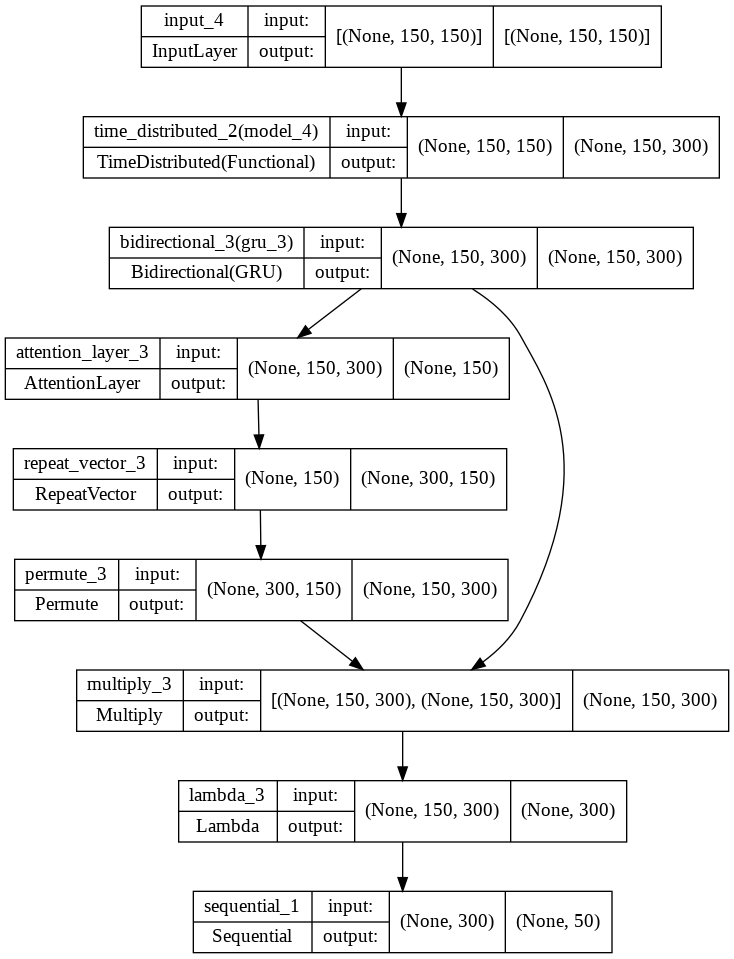

In [ ]:
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(model_top50, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
history_top50 = model_top50.fit(x=train_X_data_50,  # x : list
                    y=train_Y_data_50,  # y: list
                    batch_size= 128, # 128
                    epochs=10,  # 100
                    verbose=True,
                    validation_data=(val_X_data_50, val_Y_data_50)  # tuple , 'NoneType' object is not callable
                   # ,callbacks=[early_stop] 
                    )


# error
# def _fixup_shape(images, labels):
#    images.set_shape([None, 15, 256, 256, 3])
#    labels.set_shape([None, 12])
#    return images, labels
# as_list() is not defined on an unknown tensorshape

#model.load_weights(model_path)

Epoch 1/10
6/6 [==============================] - 134s 21s/step - loss: 0.5418 - acc: 0.0236 - val_loss: 0.3362 - val_acc: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 124s 21s/step - loss: 0.3622 - acc: 0.0361 - val_loss: 0.3374 - val_acc: 0.0250
Epoch 3/10
6/6 [==============================] - 124s 21s/step - loss: 0.3439 - acc: 0.0250 - val_loss: 0.3318 - val_acc: 0.0250
Epoch 4/10
6/6 [==============================] - 124s 21s/step - loss: 0.3341 - acc: 0.0403 - val_loss: 0.3340 - val_acc: 0.0625
Epoch 5/10
6/6 [==============================] - 124s 21s/step - loss: 0.3280 - acc: 0.0472 - val_loss: 0.3376 - val_acc: 0.0625
Epoch 6/10
6/6 [==============================] - 125s 21s/step - loss: 0.3265 - acc: 0.0417 - val_loss: 0.3388 - val_acc: 0.0250
Epoch 7/10
6/6 [==============================] - 124s 21s/step - loss: 0.3261 - acc: 0.0458 - val_loss: 0.3405 - val_acc: 0.0250
Epoch 8/10
6/6 [==============================] - 125s 21s/step - loss: 0.3239 - acc: 

In [ ]:
history_top50 = model_top50.fit(x=train_X_data_50,  # x : list
                    y=train_Y_data_50,  # y: list
                    batch_size= 128, # 128
                    epochs=10,  # 100
                    verbose=True,
                    validation_data=(val_X_data_50, val_Y_data_50)  # tuple , 'NoneType' object is not callable
                   ,callbacks=[early_stop] 
                    )

# word/sentence attention 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn


In [ ]:
sent1 = train_x_data[10];sent1

'admission date date of birth service medicine allergies gluten betalactams vancomycin hcl attending chief complaint fevers neutropenia major surgical or invasive procedure skin biopsy history of present illness associated t cell lymphoma dxed in autologous stem cell transplant. his post transplant course has been complicated by an upper gi bleed with egd demonstrating pud episode of bell??????s palsy and pancytopenia. the suspicion is for bone marrow involvement of his t cell lymphoma but this has not been marrow biopsy and flow cytometry. he presented to clinic today for platelet infusion and his vitals were the following t . bp pulse min. he was given tylenol l of ns over hours and blood cultures were obtained from peripheral site and picc line. also sent ua urine cultures and will have chest xray. he was given cefepime gm iv and neupogen mcg. past medical history . sprue diagnosis diet at which point prednisone therapy was initiated. further investigation led to biopsy of small bow

In [ ]:
tokenized_sentences = doc2hierarchical(sent1);tokenized_sentences

array([[    0,     0,     0, ...,  2604,   422,   602],
       [    0,     0,     0, ...,   551,     4, 13505],
       [    0,     0,     0, ...,  4360,     2,  3487],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int32)

In [ ]:
pred_word_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0];pred_word_attention.shape  # (150, 150)

(150, 150)

In [ ]:
pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0];pred_sent_attention.shape  # (150,)

(150,)

In [ ]:
print(pred_sent_attention[10])
print(sent_tokenize(sent1)[10])

# 두개를 매칭 시켜서 시각화를 해야함

0.019119084
sprue diagnosis diet at which point prednisone therapy was initiated.


In [ ]:
sent_token = sent_tokenize(sent1);sent_token

['admission date date of birth service medicine allergies gluten betalactams vancomycin hcl attending chief complaint fevers neutropenia major surgical or invasive procedure skin biopsy history of present illness associated t cell lymphoma dxed in autologous stem cell transplant.',
 'his post transplant course has been complicated by an upper gi bleed with egd demonstrating pud episode of bell?????',
 '?s palsy and pancytopenia.',
 'the suspicion is for bone marrow involvement of his t cell lymphoma but this has not been marrow biopsy and flow cytometry.',
 'he presented to clinic today for platelet infusion and his vitals were the following t .',
 'bp pulse min.',
 'he was given tylenol l of ns over hours and blood cultures were obtained from peripheral site and picc line.',
 'also sent ua urine cultures and will have chest xray.',
 'he was given cefepime gm iv and neupogen mcg.',
 'past medical history .',
 'sprue diagnosis diet at which point prednisone therapy was initiated.',
 'fu

In [ ]:
# word attention 값 출력
def word_att(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]# word attention만 가져오기
    return pred_word_attention

# sentence attention 값 출력
def sent_att(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0]
    
    # 문장단위로 뽑아줌
    return pred_sent_attention

# Visualization 

In [ ]:
import matplotlib.colors as mcl
from matplotlib.colors import LinearSegmentedColormap
h = 24
s = 0.99
v = 1

colors = [
    mcl.hsv_to_rgb((h/360,0,v)),
    mcl.hsv_to_rgb((h/360,0.5,v)),
    mcl.hsv_to_rgb((h/360,1,v))
]
cmap = LinearSegmentedColormap.from_list('my_cmap',colors,gamma=3)

In [ ]:
# word attention 시각화
def word_att_vis(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap=cmap, center=midpoint, vmin=0, vmax=1,annot=True)  # coolwarm
        plt.xticks(rotation=45)
        plt.show()
        

In [ ]:
# sentence attention 시각화

def sent_att_vis(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    
    # sentence attention만 가져오기
    pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0] # sentence attention을 추출함
    
    # 문장단위로 나누는 시행
    sent_token = sent_tokenize(review) # 문장단위로 뽑아줌
    midpoint = (max(pred_sent_attention) - min(pred_sent_attention)) / 2 # attention 값의 mid point를 결정해줌
    
    # pred_sent_attention 와 sent_token을 한꺼번에 표시해줘야함

    for sent_idx, sentence in enumerate(sent_token): # 150개의 문장이 하나씩 들어가게됨, sent_idx는 0~149까지 가게됨
        pred_att = pred_sent_attention[sent_idx] # sentence 와 이에 해당하는 attention값을 매칭시켜줌
        pred_att = np.expand_dims(pred_att, axis=0)
        pred_att = np.expand_dims(pred_att, axis=0)
        fig, ax = plt.subplots(figsize=(20, 1))
        plt.rc('xtick', labelsize=10)
        heatmap = sn.heatmap(pred_att, xticklabels=False, yticklabels=pred_att, square=True, linewidths=0.1, cmap=cmap, center=midpoint, vmin=0, vmax=1,annot=True) # coolwarm
        #plt.xlabel(sentence, size=10)
        plt.show()
        print(sentence)


#  'reds' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magm...

In [ ]:
# sent1="Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!"
sent1 = train_x_data[100];sent1

'admission date date of birth service surgery allergies patient recorded as having no known allergies to drugs attending chief complaint s p pedestrian struck by auto major surgical or invasive procedure orif right knee reconstruction ivc filter placement history of present illness yo female pedestrian who was struck by auto traveling at unknown rate of speed initialy combative at scene requiring intubation for airway protection. she was transferred to via past medical history none known family history noncontributory physical exam upon admission hr bp rr paralyzed intubated heent perrla neck c collar chest cta bilat cor rrr abd soft nd fast negative rectum tone decreased pelvis blood out of vagina stable extr left femur fracture pulses palp lle right unstrable knee with palp pulses rle pertinent results potassium . chloride total co anion gap mcv mch . mchc . rdw . ct pelvis impression . multiple fractures are seen involving the pelvis as described above.there is no evidence of intra 

[[3.6103515e-07 3.5045397e-07 3.4840949e-07 ... 1.4795756e-02
  1.4955413e-01 2.2835217e-02]
 [4.0448973e-07 3.9291325e-07 3.9067217e-07 ... 2.2879999e-02
  3.6116326e-03 1.5863921e-02]
 [9.5694319e-05 9.2928516e-05 9.2393544e-05 ... 1.4770678e-02
  3.9245989e-02 7.5104535e-01]
 ...
 [6.9260295e-03 6.7273742e-03 6.6889292e-03 ... 6.7041861e-03
  6.7573637e-03 7.0041637e-03]
 [6.9260295e-03 6.7273742e-03 6.6889292e-03 ... 6.7041861e-03
  6.7573637e-03 7.0041637e-03]
 [6.9260295e-03 6.7273742e-03 6.6889292e-03 ... 6.7041861e-03
  6.7573637e-03 7.0041637e-03]]


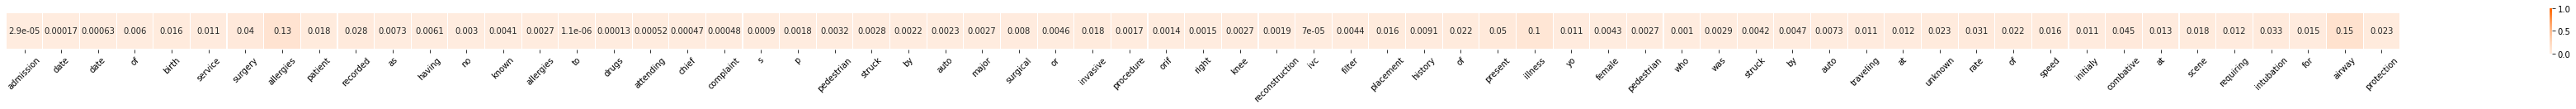

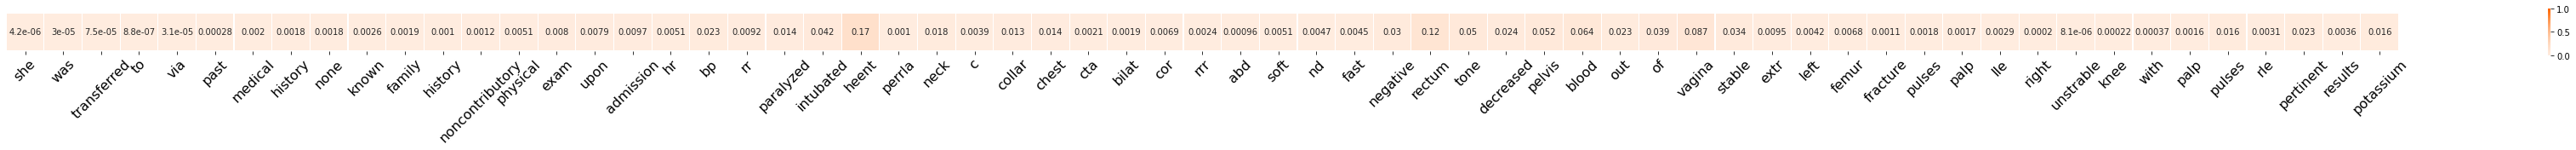

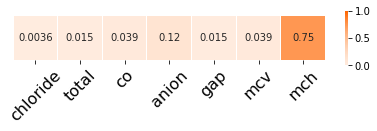

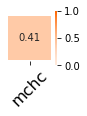

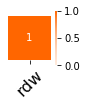

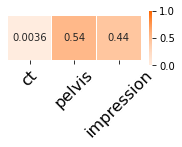

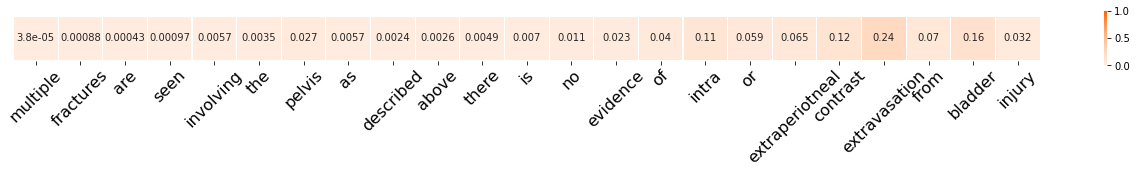

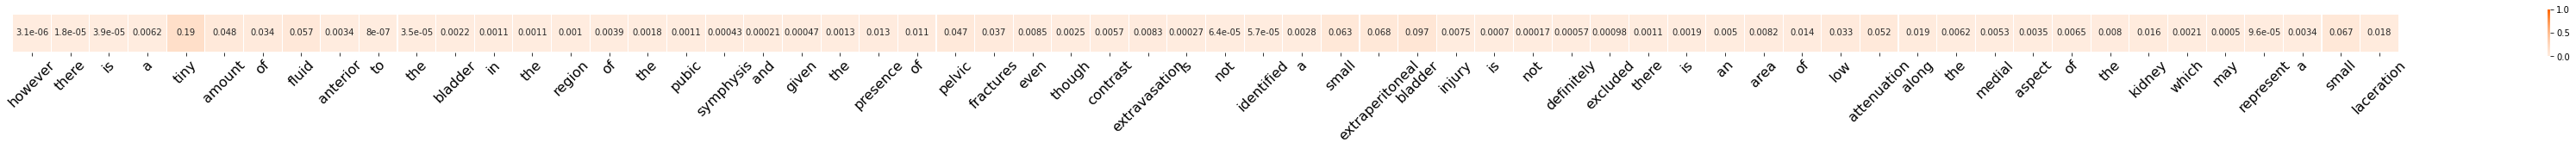

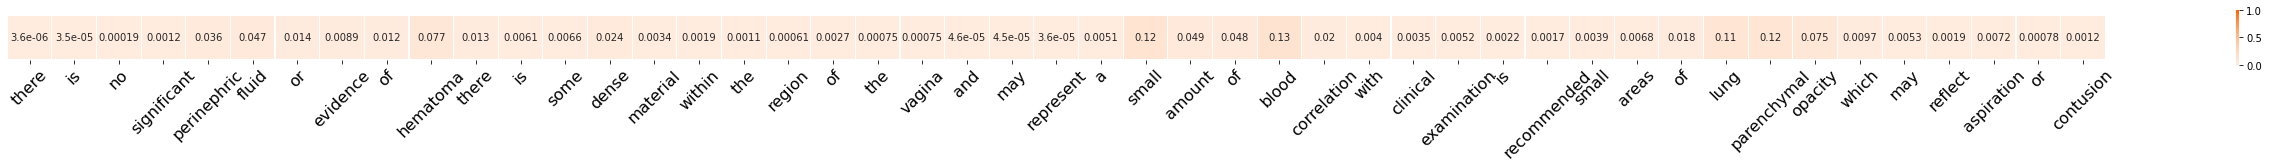

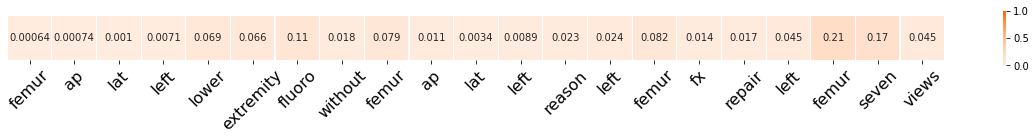

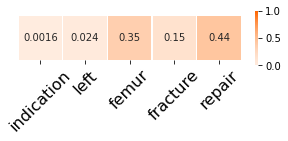

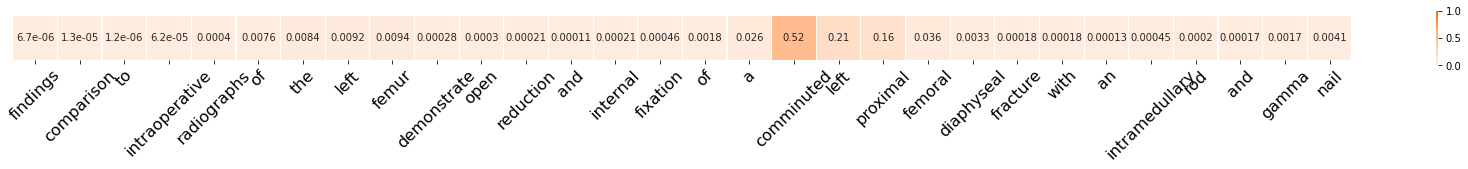

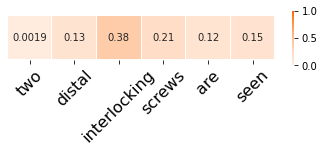

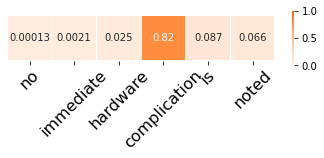

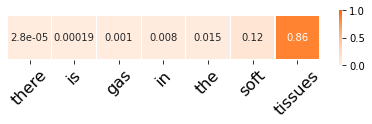

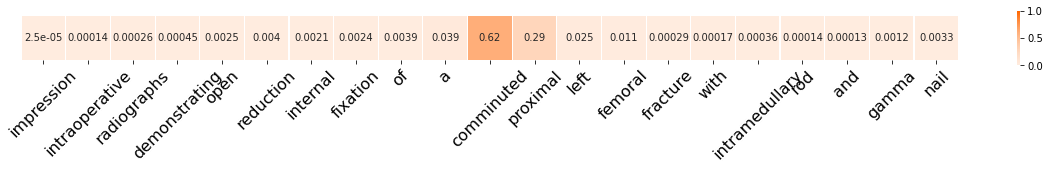

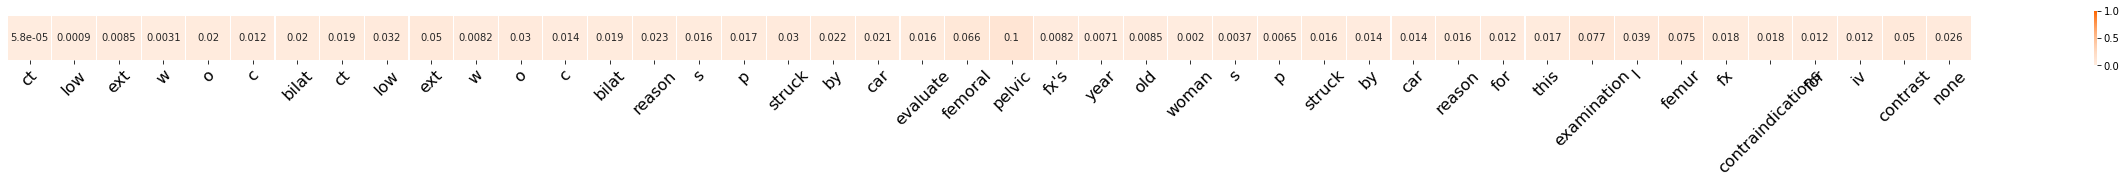

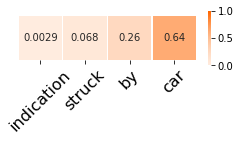

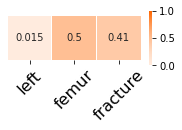

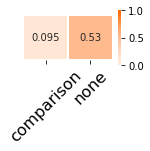

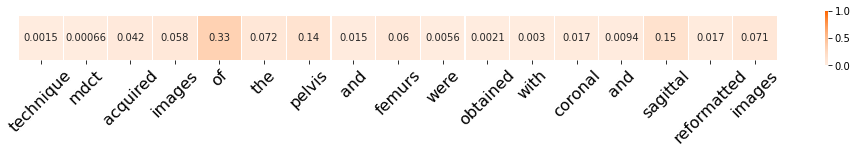

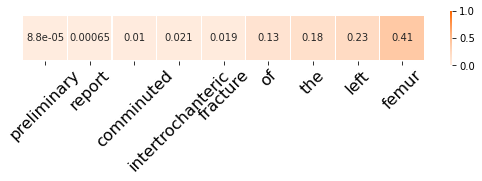

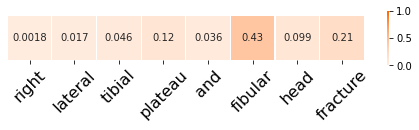

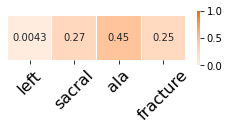

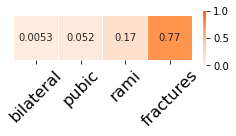

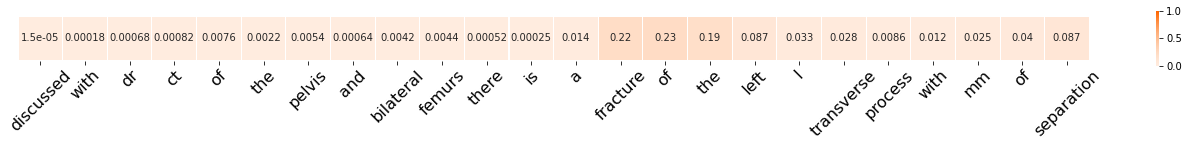

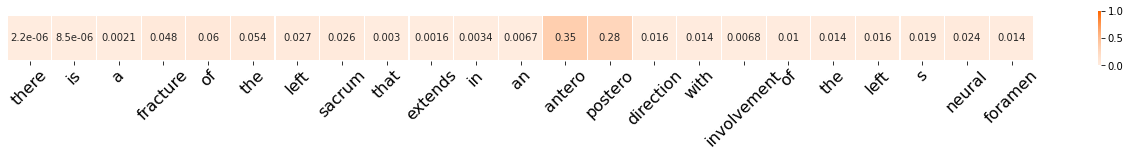

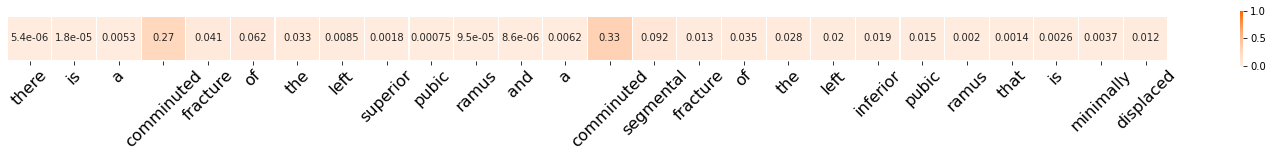

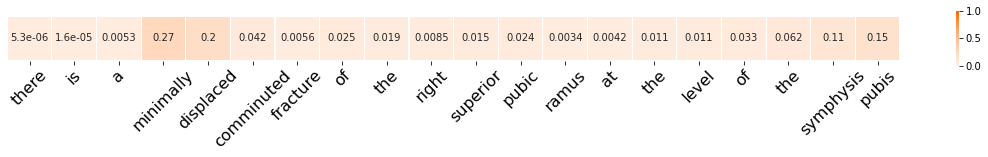

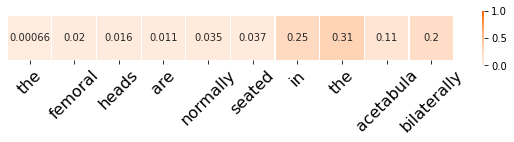

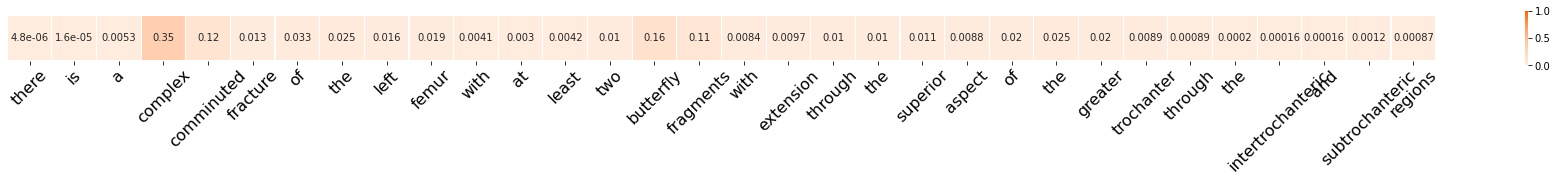

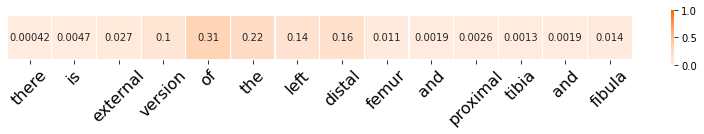

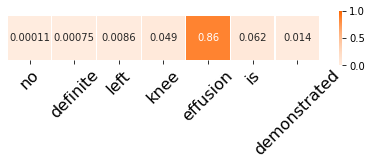

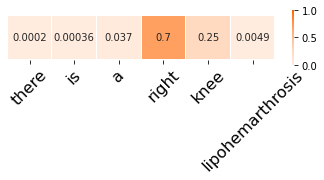

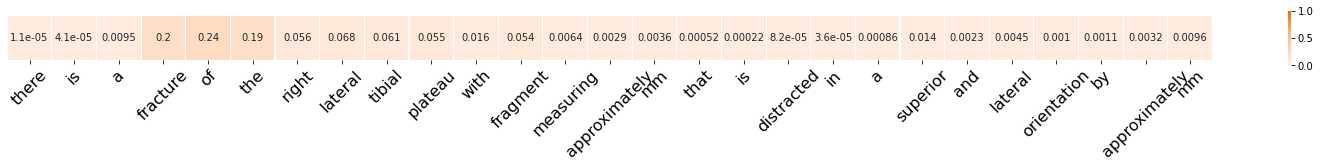

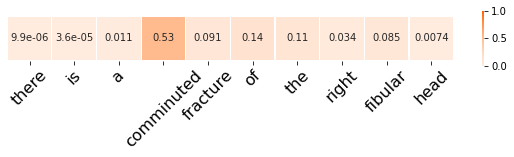

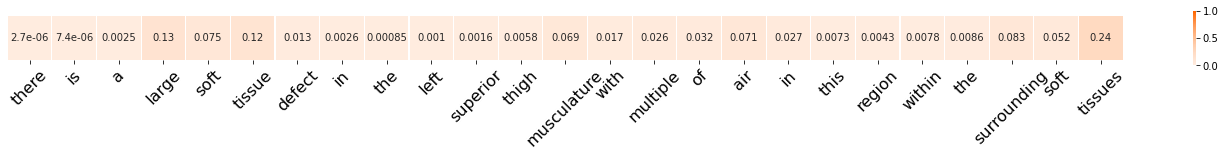

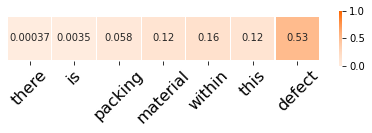

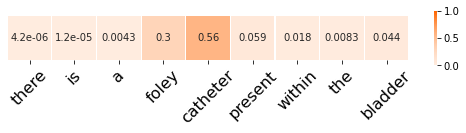

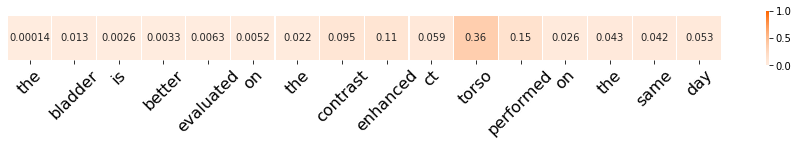

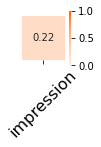

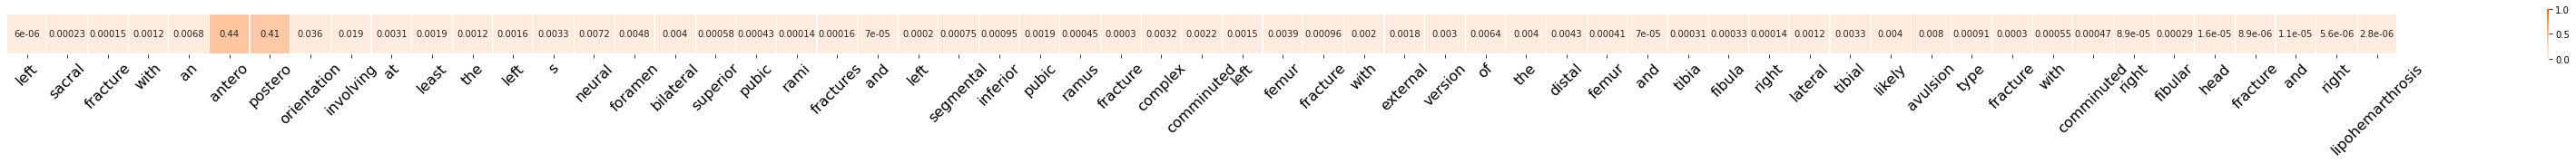

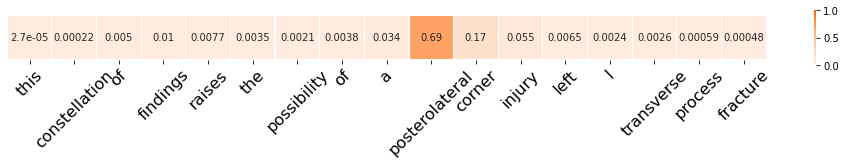

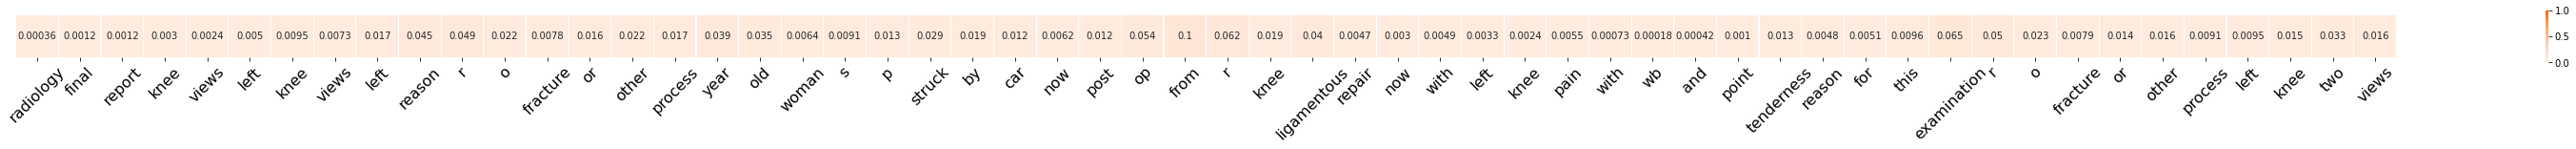

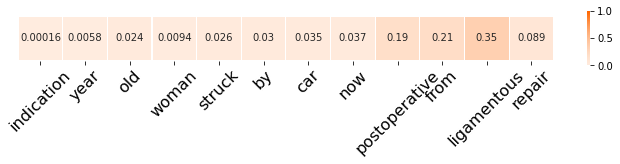

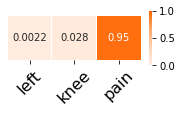

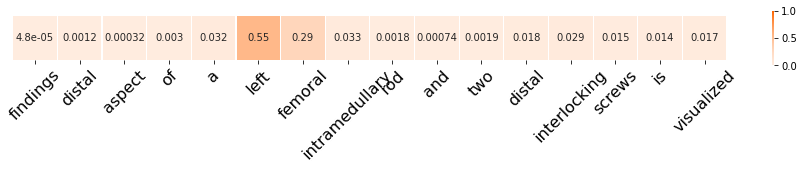

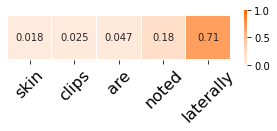

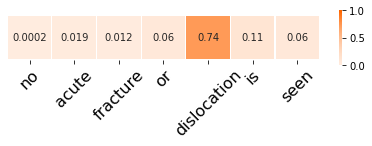

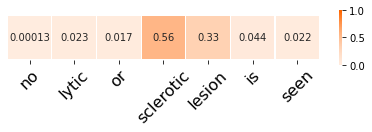

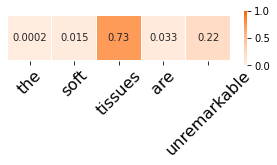

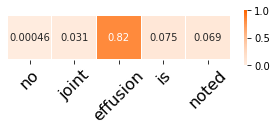

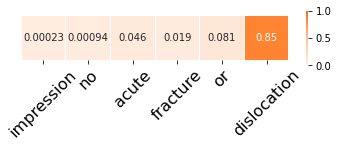

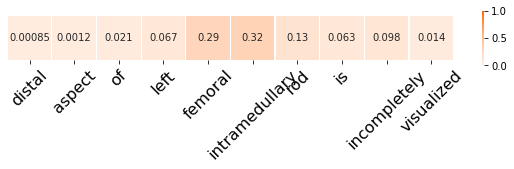

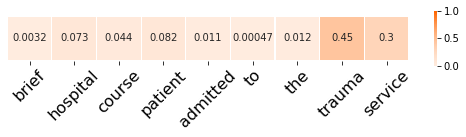

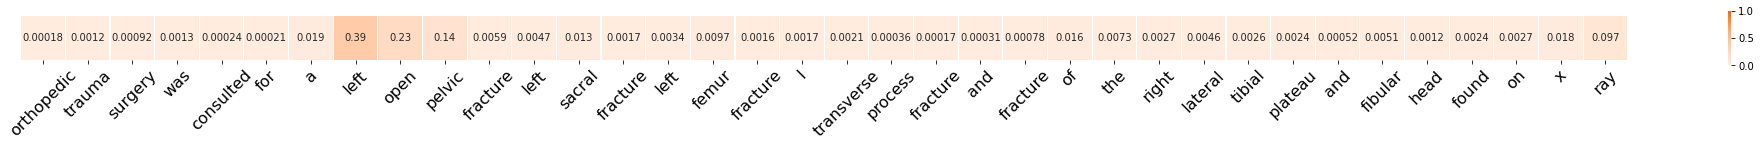

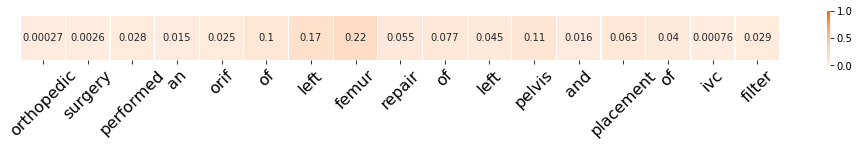

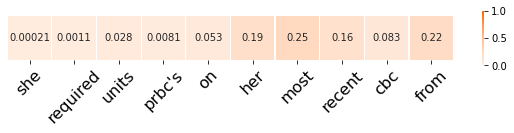

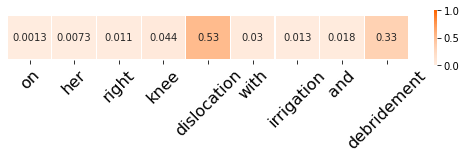

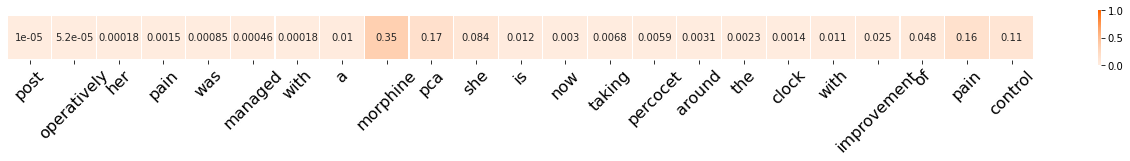

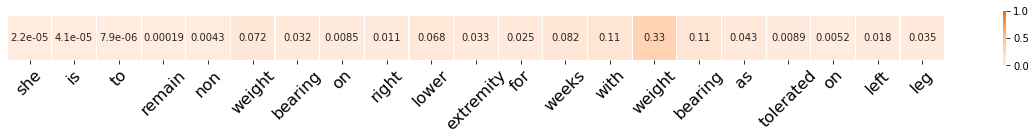

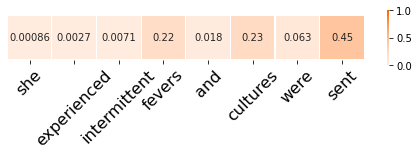

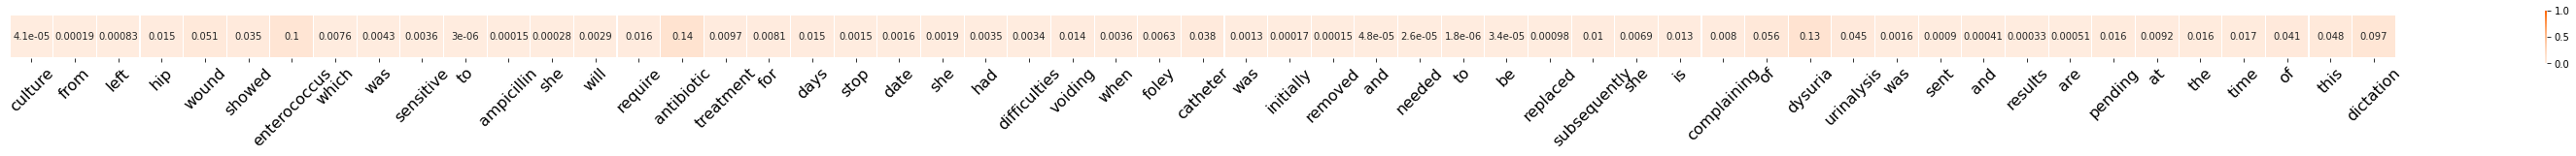

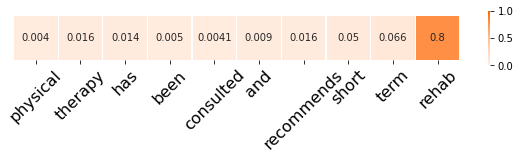

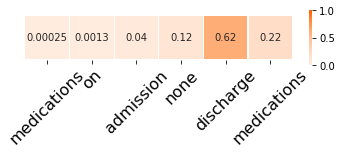

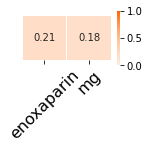

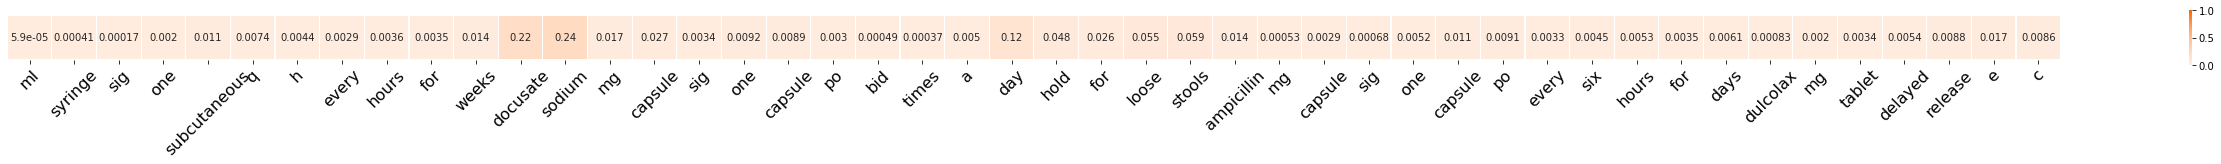

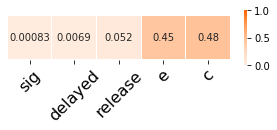

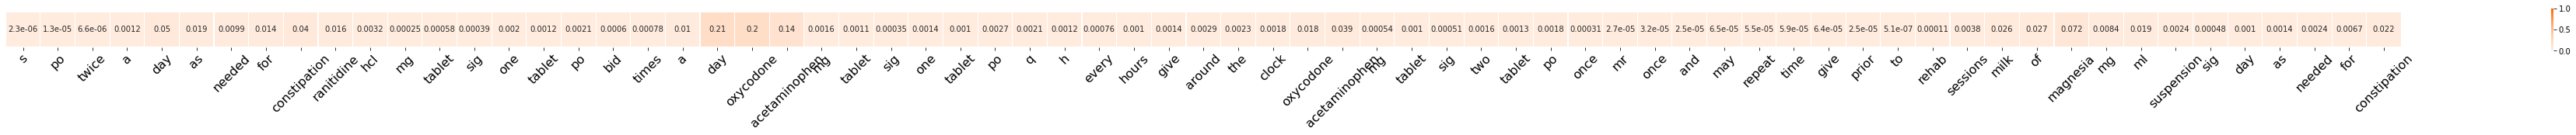

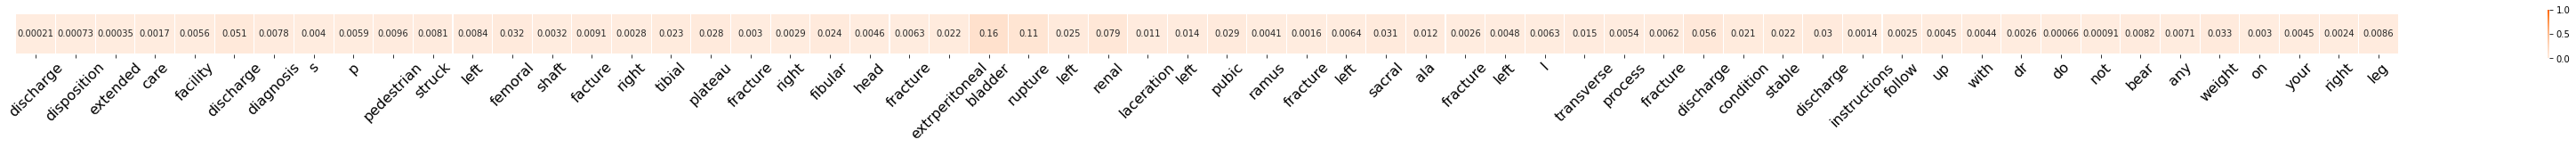

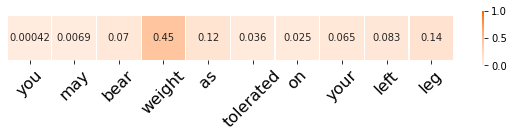

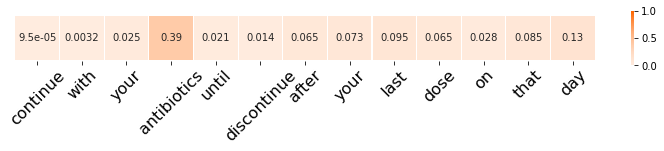

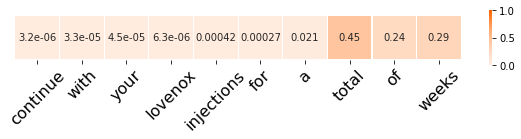

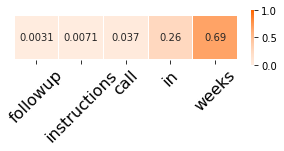

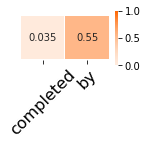

In [ ]:
#1.
print(word_att(sent1))
word_att_vis(sent1)

[4.8084553e-02 2.1420859e-03 7.3593520e-03 1.9352500e-04 2.0552121e-04
 3.1830836e-04 4.7853999e-04 1.7516405e-04 2.2015610e-04 3.8651994e-04
 2.7456836e-04 1.4435807e-04 4.9940654e-04 1.1050662e-03 7.3389811e-03
 1.8089601e-04 8.7705482e-04 9.6193526e-04 2.2086248e-04 1.5506987e-04
 2.0801237e-04 3.2454080e-04 2.6128927e-04 6.0667744e-04 2.2103412e-03
 4.4667814e-04 1.2556517e-02 2.8976944e-04 6.3326728e-04 3.6699404e-03
 5.8132020e-04 3.6858927e-04 1.6735269e-03 1.5484363e-04 1.3998445e-04
 1.4950903e-04 5.2649569e-04 1.9285870e-03 2.8668498e-04 3.8245614e-03
 3.3920089e-04 2.5242634e-02 1.6287458e-04 6.0825149e-04 6.9757761e-04
 8.8637491e-04 1.7807238e-04 1.5004876e-03 3.3880922e-03 3.6774694e-03
 1.9694455e-02 3.1123159e-03 6.6206511e-03 6.1833696e-04 9.9218555e-04
 1.9991423e-04 4.5703666e-04 1.6887659e-02 3.8650043e-03 1.7064863e-03
 8.1318710e-03 4.2331412e-02 4.6503022e-02 1.6568643e-01 5.2973038e-01
 3.5723549e-04 3.7656509e-04 1.2341809e-03 1.0650912e-03 4.4924865e-04
 7.499

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


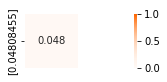

admission date date of birth service surgery allergies patient recorded as having no known allergies to drugs attending chief complaint s p pedestrian struck by auto major surgical or invasive procedure orif right knee reconstruction ivc filter placement history of present illness yo female pedestrian who was struck by auto traveling at unknown rate of speed initialy combative at scene requiring intubation for airway protection.


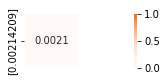

she was transferred to via past medical history none known family history noncontributory physical exam upon admission hr bp rr paralyzed intubated heent perrla neck c collar chest cta bilat cor rrr abd soft nd fast negative rectum tone decreased pelvis blood out of vagina stable extr left femur fracture pulses palp lle right unstrable knee with palp pulses rle pertinent results potassium .


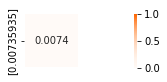

chloride total co anion gap mcv mch .


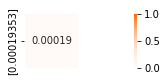

mchc .


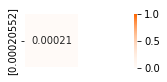

rdw .


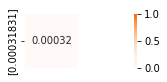

ct pelvis impression .


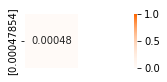

multiple fractures are seen involving the pelvis as described above.there is no evidence of intra or extraperiotneal contrast extravasation from bladder injury.


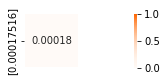

however there is a tiny amount of fluid anterior to the bladder in the region of the pubic symphysis and given the presence of pelvic fractures even though contrast extravasation is not identified a small extraperitoneal bladder injury is not definitely excluded.there is an area of low attenuation along the medial aspect of the kidney which may represent a small laceration.


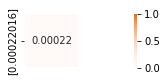

there is no significant perinephric fluid or evidence of hematoma.there is some dense material within the region of the vagina and may represent a small amount of blood correlation with clinical examination is recommended.small areas of lung parenchymal opacity which may reflect aspiration or contusion.


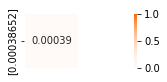

femur ap & lat left lower extremity fluoro without femur ap & lat left reason left femur fx repair left femur seven views.


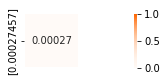

indication left femur fracture repair.


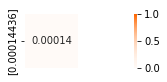

findings comparison to intraoperative radiographs of the left femur demonstrate open reduction and internal fixation of a comminuted left proximal femoral diaphyseal fracture with an intramedullary rod and gamma nail.


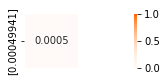

two distal interlocking screws are seen.


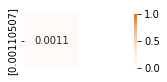

no immediate hardware complication is noted.


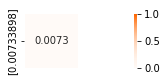

there is gas in the soft tissues.


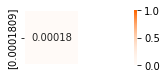

impression intraoperative radiographs demonstrating open reduction internal fixation of a comminuted proximal left femoral fracture with intramedullary rod and gamma nail.


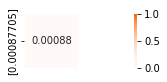

ct low ext w o c bilat ct low ext w o c bilat reason s p struck by car evaluate femoral pelvic fx's year old woman s p struck by car reason for this examination l. femur fx contraindications for iv contrast none.


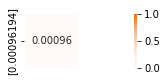

indication struck by car.


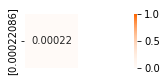

left femur fracture.


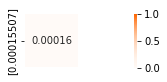

comparison none.


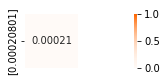

technique mdct acquired images of the pelvis and femurs were obtained with coronal and sagittal reformatted images.


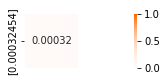

preliminary report "comminuted intertrochanteric fracture of the left femur.


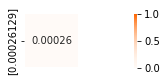

right lateral tibial plateau and fibular head fracture.


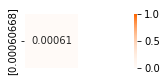

left sacral ala fracture.


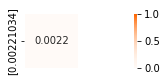

bilateral pubic rami fractures.


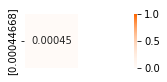

discussed with dr. ct of the pelvis and bilateral femurs there is a fracture of the left l transverse process with mm of separation.


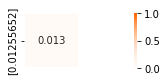

there is a fracture of the left sacrum that extends in an antero postero direction with involvement of the left s neural foramen.


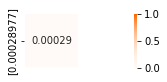

there is a comminuted fracture of the left superior pubic ramus and a comminuted segmental fracture of the left inferior pubic ramus that is minimally displaced.


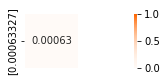

there is a minimally displaced comminuted fracture of the right superior pubic ramus at the level of the symphysis pubis.


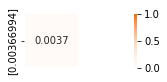

the femoral heads are normally seated in the acetabula bilaterally.


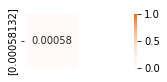

there is a complex comminuted fracture of the left femur with at least two butterfly fragments with extension through the superior aspect of the greater trochanter through the intertrochanteric and subtrochanteric regions.


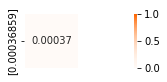

there is external version of the left distal femur and proximal tibia and fibula.


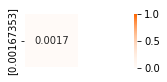

no definite left knee effusion is demonstrated.


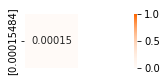

there is a right knee lipohemarthrosis.


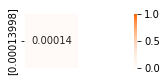

there is a fracture of the right lateral tibial plateau with fragment measuring approximately mm that is distracted in a superior and lateral orientation by approximately mm.


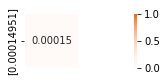

there is a comminuted fracture of the right fibular head.


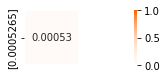

there is a large soft tissue defect in the left superior thigh musculature with multiple of air in this region within the surrounding soft tissues.


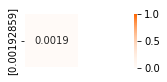

there is packing material within this defect.


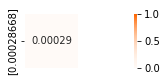

there is a foley catheter present within the bladder.


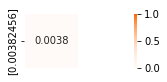

the bladder is better evaluated on the contrast enhanced ct torso performed on the same day.


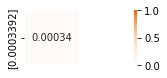

impression .


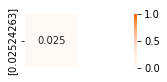

left sacral fracture with an antero postero orientation involving at least the left s neural foramen.bilateral superior pubic rami fractures and left segmental inferior pubic ramus fracture.complex comminuted left femur fracture with external version of the distal femur and tibia fibula.right lateral tibial likely avulsion type fracture with comminuted right fibular head fracture and right lipohemarthrosis.


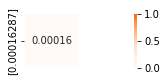

this constellation of findings raises the possibility of a posterolateral corner injury.left l transverse process fracture.


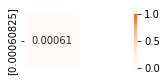

radiology final report knee views left knee views left reason r o fracture or other process year old woman s p struck by car now post op from r knee ligamentous repair now with left knee pain with wb and point tenderness reason for this examination r o fracture or other process left knee two views.


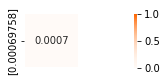

indication year old woman struck by car now postoperative from ligamentous repair.


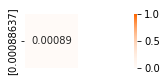

left knee pain.


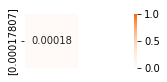

findings distal aspect of a left femoral intramedullary rod and two distal interlocking screws is visualized.


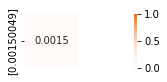

skin clips are noted laterally.


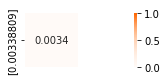

no acute fracture or dislocation is seen.


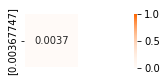

no lytic or sclerotic lesion is seen.


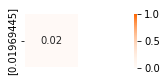

the soft tissues are unremarkable.


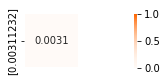

no joint effusion is noted.


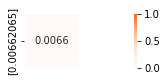

impression no acute fracture or dislocation.


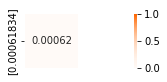

distal aspect of left femoral intramedullary rod is incompletely visualized.


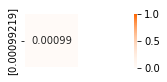

brief hospital course patient admitted to the trauma service.


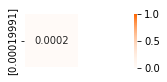

orthopedic trauma surgery was consulted for a left open pelvic fracture left sacral fracture left femur fracture l transverse process fracture and fracture of the right lateral tibial plateau and fibular head found on x ray.


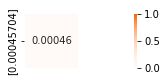

orthopedic surgery performed an orif of left femur repair of left pelvis and placement of ivc filter.


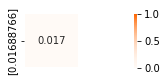

she required units prbc's on her most recent cbc from .


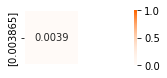

on her right knee dislocation with irrigation and debridement.


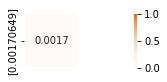

post operatively her pain was managed with a morphine pca she is now taking percocet around the clock with improvement of pain control.


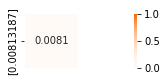

she is to remain non weight bearing on right lower extremity for weeks with weight bearing as tolerated on left leg.


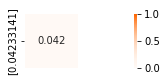

she experienced intermittent fevers and cultures were sent.


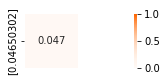

culture from left hip wound showed enterococcus which was sensitive to ampicillin she will require antibiotic treatment for days stop date she had difficulties voiding when foley catheter was initially removed and needed to be replaced subsequently she is complaining of dysuria urinalysis was sent and results are pending at the time of this dictation.


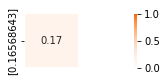

physical therapy has been consulted and recommends short term rehab.


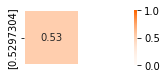

medications on admission none discharge medications .


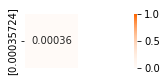

enoxaparin mg .


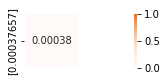

ml syringe sig one subcutaneous q h every hours for weeks.docusate sodium mg capsule sig one capsule po bid times a day hold for loose stools.ampicillin mg capsule sig one capsule po every six hours for days.dulcolax mg tablet delayed release e.c.


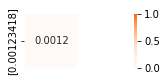

sig delayed release e.c.


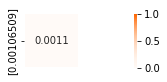

s po twice a day as needed for constipation.ranitidine hcl mg tablet sig one tablet po bid times a day .oxycodone acetaminophen mg tablet sig one tablet po q h every hours give around the clock.oxycodone acetaminophen mg tablet sig two tablet po once mr once and may repeat time give prior to rehab sessions.milk of magnesia mg ml suspension sig day as needed for constipation.


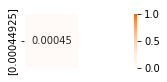

discharge disposition extended care facility discharge diagnosis s p pedestrian struck left femoral shaft facture right tibial plateau fracture right fibular head fracture extrperitoneal bladder rupture left renal laceration left pubic ramus fracture left sacral ala fracture left l transverse process fracture discharge condition stable discharge instructions follow up with dr. do not bear any weight on your right leg.


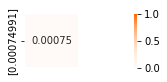

you may bear weight as tolerated on your left leg.


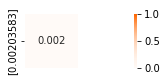

continue with your antibiotics until discontinue after your last dose on that day.


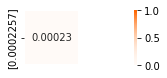

continue with your lovenox injections for a total of weeks.


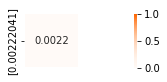

followup instructions call in weeks.


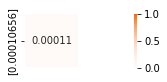

completed by


In [ ]:
#2.
print(sent_att(sent1))
sent_att_vis(sent1)

# extracting text

In [ ]:
# word attention의 word들을 뽑아서 
threshold = 0.005 # 임의로 정해봄 0.1/0.05/0.01/0.005 4가지 수행해볼예정

In [ ]:
import pandas as pd

df = pd.DataFrame(columns = {'word','att','logic'}) 
word_list = []
att_list = []
#word_list = pd.DataFrame(columns = {'word'}) 
#att_list = pd.DataFrame(columns = {'att'}) 
df

tokenized_sentences = doc2hierarchical(final_data['TEXT'][1])
pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]

print(tokenized_sentences)
print(pred_attention)

print(tokenized_sentences.shape)
print(pred_attention.shape)

[[    0     0     0 ...     1 11876   551]
 [    0     0     0 ...    18   569    41]
 [    0     0     0 ...   538   352    71]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]
[[4.3016777e-07 4.1164580e-07 4.1051752e-07 ... 3.4280445e-02
  6.3913840e-01 3.6637790e-03]
 [1.2700777e-05 1.2115629e-05 1.2086802e-05 ... 2.7078580e-02
  6.3747875e-02 2.7836107e-03]
 [1.0288451e-05 9.8847722e-06 9.8632927e-06 ... 4.5730226e-04
  1.0685428e-03 7.3131598e-03]
 ...
 [6.9571417e-03 6.6370568e-03 6.6210432e-03 ... 7.0645376e-03
  7.2690062e-03 7.8602545e-03]
 [6.9571417e-03 6.6370568e-03 6.6210432e-03 ... 7.0645376e-03
  7.2690062e-03 7.8602545e-03]
 [6.9571417e-03 6.6370568e-03 6.6210432e-03 ... 7.0645376e-03
  7.2690062e-03 7.8602545e-03]]
(150, 150)
(150, 150)


In [ ]:
for sent_idx, sentence in enumerate(tokenized_sentences):

    if sentence[-1] == 0:
        continue
        
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if sentence[word_idx] != 0 :  # word index 가 0이 아닌 부분만 붙이기 / 필요한 word들만 뽑음
            words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]  
            pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
            pred_att = pred_attention[sent_idx][-len(words):]
            # pred_att = np.expand_dims(pred_att, axis=0)
            print(words)
            print(pred_att)
            for i  in range(len(words)):
              word_list.append(words[i])
              att_list.append(pred_att[i]) # [word_idx]
            break
    word_list.append(".")
    att_list.append(0)
        
df['word'] = word_list 
df['att'] = att_list
df

['admission', 'date', 'date', 'of', 'birth', 'service', 'history', 'of', 'present', 'illness', 'the', 'patient', 'is', 'a', 'year', 'old', 'woman', 'status', 'post', 'coronary', 'artery', 'bypass', 'grafting', 'times', 'three', 'on', 'to', 'admission', 'noted', 'increasing', 'redness', 'of', 'her', 'right', 'lower', 'extremity', 'at', 'the', 'saphenectomy', 'site']
[7.6813718e-05 1.6573711e-05 1.5133569e-05 2.1298161e-05 3.2388503e-05
 5.8288635e-05 3.3392127e-05 2.2396489e-05 7.7969358e-05 1.4057364e-04
 6.9122361e-05 1.1144847e-04 7.4202990e-06 2.7541359e-06 1.0114094e-03
 4.0719723e-03 8.0787687e-04 2.8066394e-01 5.2220351e-04 2.4715092e-02
 1.5322331e-03 2.0362949e-03 1.0928233e-04 8.0751051e-05 6.3393411e-05
 1.9465942e-05 8.8328397e-06 2.5918626e-04 1.5960602e-04 4.1034745e-04
 4.2373722e-06 8.3355972e-06 1.9310110e-05 4.2192626e-04 1.8245920e-03
 1.2178647e-04 3.3141607e-03 3.4280445e-02 6.3913840e-01 3.6637790e-03]
['she', 'denied', 'fevers', 'chills', 'or', 'leg', 'pain']
[0.0

,att,logic,word
0,0.000077,NaN,admission
1,0.000017,NaN,date
2,0.000015,NaN,date
3,0.000021,NaN,of
4,0.000032,NaN,birth
...,...,...,...
581,0.004512,NaN,medquist
582,0.012383,NaN,d
583,0.111392,NaN,t
584,0.864651,NaN,job


In [ ]:

for i in range(len(df)):
  if df['att'][i] > threshold  : 
    df['logic'][i] = 1
  else:
    df['logic'][i] = 0
print(len(df))
print(df)


586
          att logic       word
0    0.000077     0  admission
1    0.000017     0       date
2    0.000015     0       date
3    0.000021     0         of
4    0.000032     0      birth
..        ...   ...        ...
581  0.004512     0   medquist
582  0.012383     1          d
583  0.111392     1          t
584  0.864651     1        job
585  0.000000     0          .

[586 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#df_ = df[df['logic']==1]  
df_ = df[(df['logic'] == 1) | (df['word'] == '.')]
print(len(df_))

df_=df_.reset_index()
print(df_)
# 19로 길이가 줄어든것을 확인할 수 있음

345
     index       att logic          word
0       17  0.280664     1        status
1       19  0.024715     1      coronary
2       37  0.034280     1           the
3       38  0.639138     1  saphenectomy
4       40  0.000000     0             .
..     ...       ...   ...           ...
340    579  0.005385     1      dictated
341    582  0.012383     1             d
342    583  0.111392     1             t
343    584  0.864651     1           job
344    585  0.000000     0             .

[345 rows x 4 columns]


In [ ]:
paragraph = []
for i in range(len(df_)) : 
  paragraph.append(df_['word'][i])

In [ ]:
print(paragraph)
full_paragraph = " ".join(paragraph);  full_paragraph 
print(full_paragraph)

['status', 'coronary', 'the', 'saphenectomy', '.', 'denied', 'fevers', 'or', 'leg', '.', 'had', 'no', 'shortness', 'well', '.', 'medical', 'coronary', 'artery', 'disease', 'status', '.', 'non', 'insulin', 'dependent', 'diabetes', '.', 'hypertension', '.', 'arthritis', '.', 'total', 'abdominal', 'hysterectomy', '.', 'appendectomy', '.', 'zestril', '.', 'medications', 'lasix', 'b', 'i', 'd', '.', 'potassium', 'chloride', 'b', 'i', 'd', '.', 'b', 'i', 'd', '.', 'aspirin', 'q', 'd', '.', 'glipizide', 'q', '.', 'lipitor', 'q', 'd', '.', 'valsartan', 'q', 'd', '.', 'lopressor', '.', 'percocet', 'p', 'r', 'n', '.', 'physical', 'examination', 'vital', 'signs', 'temperature', '.', 'rhythm', 'blood', '.', 'no', 'acute', '.', 'heent', 'pupils', '.', 'extraocular', 'movements', 'intact', '.', 'anicteric', '.', 'noninjected', '.', 'neck', 'supple', '.', 'no', 'lymphadenopathy', '.', 'cardiovascular', 'regular', 'and', 'rhythm', '.', 'with', 'diminished', 'at', 'the', 'bases', '.', 'abdomen', 'and',

In [ ]:
# 여러 document에 적용하기 위하여 def 함수로 정의하기

def word_att_pair(review):  # review 에는 1개의 document가 들어가게됨
    df = pd.DataFrame(columns={'word', 'att', 'logic'}) # 여기에 데이터가 들어갈 예정임
    word_list = [] # word_list = pd.DataFrame(columns = {'word'})
    att_list = [] # att_list = pd.DataFrame(columns = {'att'})
    tokenized_sentences = doc2hierarchical(review)
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]

    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue

        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:  # word index 가 0이 아닌 부분만 붙이기 / 필요한 word들만 뽑음
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]

                pred_att = pred_attention[sent_idx][-len(words):]
                # pred_att = np.expand_dims(pred_att, axis=0)
                #print(words)
                #print(pred_att)
                for i in range(len(words)):
                    word_list.append(words[i])
                    att_list.append(pred_att[i])  # [word_idx]
                break
        word_list.append(".")
        att_list.append(0)

    df['word'] = word_list
    df['att'] = att_list
    return df  # df 는 한개의  document에 대해서 word , att pair를 보여주는 데이터 프레임

def extract_words(df):
    for i in range(len(df)):
        if df['att'][i] > threshold:
            df['logic'][i] = 1
        else:
            df['logic'][i] = 0
    df_ = df[(df['logic'] == 1) | (df['word'] == '.')]
    df_ = df_.reset_index()  # index가 뒤죽박죽이라 reset을 한번 해줌
    paragraph = []
    for i in range(len(df_)):
        paragraph.append(df_['word'][i])
    full_paragraph = " ".join(paragraph)
    return paragraph , full_paragraph


In [ ]:
reduced_doc= []

for i in range(len(final_data['TEXT'])):  # documnet수만큼 진행됨
    df = word_att_pair(final_data['TEXT'][i]) # i 번쨰 document의 text가 input으로 들어감
    parag, f_parag = extract_words(df)
    reduced_doc.append(f_parag) # reduced_doc에 줄어든 text가 들어가게됨

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# sentence representation (doc2vec)

In [ ]:
# doc2vec사용해서 문장별 embedding 진행하기
# 참고 : https://swlock.blogspot.com/2020/02/doc2vec-2.html
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim 
import gensim.downloader as api 
from gensim.test.utils import common_texts
from gensim.test.utils import get_tmpfile

In [ ]:
dataset = final_data['TEXT']
sent = [ d for d in dataset] ; sent
print(len(sent))  # 총 12808개의 documents 
print(sent[0])
print(sent[0].split()) # documnet별로 나뉨

12808
admission date date of birth service cardiothoracic allergies bactrim ampicillin remeron attending chief complaint chest pressure cardiac tamponade cardiogenic shock major surgical or invasive procedure emergent sternotomy for pericardial window history of present illness underwent min. inv. pfo closure in on and chest pain for several days. did not resolve with pain med and had increasing sob. admitted to er for emergent eval. and bedside tte. started on dopamine drip for hypotension. past medical history s p min. inv. closure of patent foramen ovale stroke tia depression anxiety borderline hyperlipidemia herniation of cervical discs patella femoral syndrome s p bunionectomies social history denies tobacco. admits to occasional etoh. she is an employee of the children. she denies ivda and recreational drugs. family history father underwent cabg at age . cousin died of an mi at age . physical exam pt. in distress sbp 's lungs cta tachycardic rr no murmur or rubs palpable pedal pu

In [ ]:
# 문장단위로 나눠야함
print(len(sent_tokenize(sent[0]))) # 총 51개의 문장이 들어감을 알 수 있음 / 51개
sent_tokenize(sent[0])

51


['admission date date of birth service cardiothoracic allergies bactrim ampicillin remeron attending chief complaint chest pressure cardiac tamponade cardiogenic shock major surgical or invasive procedure emergent sternotomy for pericardial window history of present illness underwent min.',
 'inv.',
 'pfo closure in on and chest pain for several days.',
 'did not resolve with pain med and had increasing sob.',
 'admitted to er for emergent eval.',
 'and bedside tte.',
 'started on dopamine drip for hypotension.',
 'past medical history s p min.',
 'inv.',
 'closure of patent foramen ovale stroke tia depression anxiety borderline hyperlipidemia herniation of cervical discs patella femoral syndrome s p bunionectomies social history denies tobacco.',
 'admits to occasional etoh.',
 'she is an employee of the children.',
 'she denies ivda and recreational drugs.',
 'family history father underwent cabg at age .',
 'cousin died of an mi at age .',
 'physical exam pt.',
 "in distress sbp 's 

In [ ]:
token_list = []
sentence_list = []

for i in range(len(sent)): # len(sent) : 총 document수 
  sent_token = sent_tokenize(sent[i])  # i 번째 document에 대해서  문장단위로 쪼갬
  for j in range(len(sent_token)):  # i번째 document의 문장수에 따라서 값이 바뀔 수 있음
    sentence_list.append(sent_token[j].split())
  

In [ ]:
print(len(sentence_list))
print(sentence_list[1000])
print(sentence_list[2000])

1202978
['ml', 'syringe', 'sig', 'one', 'mg', 'subcutaneous', 'twice', 'a', 'day', 'for', 'weeks.']
['history', 'of', 'vaginal', 'bleeding', 'depoprovera', 'injection', 'requiring', 'transfusion', '.']


In [ ]:
sent_tokenize(sent[0])

['admission date date of birth service cardiothoracic allergies bactrim ampicillin remeron attending chief complaint chest pressure cardiac tamponade cardiogenic shock major surgical or invasive procedure emergent sternotomy for pericardial window history of present illness underwent min.',
 'inv.',
 'pfo closure in on and chest pain for several days.',
 'did not resolve with pain med and had increasing sob.',
 'admitted to er for emergent eval.',
 'and bedside tte.',
 'started on dopamine drip for hypotension.',
 'past medical history s p min.',
 'inv.',
 'closure of patent foramen ovale stroke tia depression anxiety borderline hyperlipidemia herniation of cervical discs patella femoral syndrome s p bunionectomies social history denies tobacco.',
 'admits to occasional etoh.',
 'she is an employee of the children.',
 'she denies ivda and recreational drugs.',
 'family history father underwent cabg at age .',
 'cousin died of an mi at age .',
 'physical exam pt.',
 "in distress sbp 's 

In [ ]:
print(token_list[0])

['admission', 'date', 'date', 'of', 'birth', 'service', 'cardiothoracic', 'allergies', 'bactrim', 'ampicillin', 'remeron', 'attending', 'chief', 'complaint', 'chest', 'pressure', 'cardiac', 'tamponade', 'cardiogenic', 'shock', 'major', 'surgical', 'or', 'invasive', 'procedure', 'emergent', 'sternotomy', 'for', 'pericardial', 'window', 'history', 'of', 'present', 'illness', 'underwent', 'min.', 'inv.', 'pfo', 'closure', 'in', 'on', 'and', 'chest', 'pain', 'for', 'several', 'days.', 'did', 'not', 'resolve', 'with', 'pain', 'med', 'and', 'had', 'increasing', 'sob.', 'admitted', 'to', 'er', 'for', 'emergent', 'eval.', 'and', 'bedside', 'tte.', 'started', 'on', 'dopamine', 'drip', 'for', 'hypotension.', 'past', 'medical', 'history', 's', 'p', 'min.', 'inv.', 'closure', 'of', 'patent', 'foramen', 'ovale', 'stroke', 'tia', 'depression', 'anxiety', 'borderline', 'hyperlipidemia', 'herniation', 'of', 'cervical', 'discs', 'patella', 'femoral', 'syndrome', 's', 'p', 'bunionectomies', 'social', 'h

In [ ]:
print(token_list[0])
print(token_list[1])
print(token_list[2])

['admission', 'date', 'date', 'of', 'birth', 'service', 'cardiothoracic', 'allergies', 'bactrim', 'ampicillin', 'remeron', 'attending', 'chief', 'complaint', 'chest', 'pressure', 'cardiac', 'tamponade', 'cardiogenic', 'shock', 'major', 'surgical', 'or', 'invasive', 'procedure', 'emergent', 'sternotomy', 'for', 'pericardial', 'window', 'history', 'of', 'present', 'illness', 'underwent', 'min.', 'inv.', 'pfo', 'closure', 'in', 'on', 'and', 'chest', 'pain', 'for', 'several', 'days.', 'did', 'not', 'resolve', 'with', 'pain', 'med', 'and', 'had', 'increasing', 'sob.', 'admitted', 'to', 'er', 'for', 'emergent', 'eval.', 'and', 'bedside', 'tte.', 'started', 'on', 'dopamine', 'drip', 'for', 'hypotension.', 'past', 'medical', 'history', 's', 'p', 'min.', 'inv.', 'closure', 'of', 'patent', 'foramen', 'ovale', 'stroke', 'tia', 'depression', 'anxiety', 'borderline', 'hyperlipidemia', 'herniation', 'of', 'cervical', 'discs', 'patella', 'femoral', 'syndrome', 's', 'p', 'bunionectomies', 'social', 'h

In [ ]:
def tagged_document(list_of_list_of_words): 
  for i , list_of_words in enumerate(list_of_list_of_words): 
    yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i]) 

In [ ]:
list(tagged_document(sentence_list))

[TaggedDocument(words=['admission', 'date', 'date', 'of', 'birth', 'service', 'cardiothoracic', 'allergies', 'bactrim', 'ampicillin', 'remeron', 'attending', 'chief', 'complaint', 'chest', 'pressure', 'cardiac', 'tamponade', 'cardiogenic', 'shock', 'major', 'surgical', 'or', 'invasive', 'procedure', 'emergent', 'sternotomy', 'for', 'pericardial', 'window', 'history', 'of', 'present', 'illness', 'underwent', 'min.'], tags=[0]),
 TaggedDocument(words=['inv.'], tags=[1]),
 TaggedDocument(words=['pfo', 'closure', 'in', 'on', 'and', 'chest', 'pain', 'for', 'several', 'days.'], tags=[2]),
 TaggedDocument(words=['did', 'not', 'resolve', 'with', 'pain', 'med', 'and', 'had', 'increasing', 'sob.'], tags=[3]),
 TaggedDocument(words=['admitted', 'to', 'er', 'for', 'emergent', 'eval.'], tags=[4]),
 TaggedDocument(words=['and', 'bedside', 'tte.'], tags=[5]),
 TaggedDocument(words=['started', 'on', 'dopamine', 'drip', 'for', 'hypotension.'], tags=[6]),
 TaggedDocument(words=['past', 'medical', 'histo

In [ ]:
data_for_training = list(tagged_document(sentence_list)) 
print(data_for_training[:1]) 

[TaggedDocument(words=['admission', 'date', 'date', 'of', 'birth', 'service', 'cardiothoracic', 'allergies', 'bactrim', 'ampicillin', 'remeron', 'attending', 'chief', 'complaint', 'chest', 'pressure', 'cardiac', 'tamponade', 'cardiogenic', 'shock', 'major', 'surgical', 'or', 'invasive', 'procedure', 'emergent', 'sternotomy', 'for', 'pericardial', 'window', 'history', 'of', 'present', 'illness', 'underwent', 'min.'], tags=[0])]


In [ ]:
# Initialize the model : doc2vec_model = Doc2Vec(documents, vector_size=1000, window=3, min_count=1, workers=4)

model = gensim.models.doc2vec.Doc2Vec(vector_size = 100, min_count=2, epochs=50)   # min_count : 2번이상 등장하는 단어들만 사용함
model.build_vocab(data_for_training) 

In [ ]:
model.train(data_for_training, total_examples = model.corpus_count, epochs = model.epochs) # 100차원으로 벡터로 나오게 학습함

In [ ]:
print(model.infer_vector("violent means to destroy the organization".split()))

[-4.53617364e-01 -4.49830517e-02  5.08129373e-02  2.65631944e-01
  3.82306159e-01  4.80860502e-01  1.81517322e-02  3.24522227e-01
 -3.56352150e-01  2.54244775e-01  2.73312628e-01 -2.37095430e-01
 -1.39910907e-01  4.47603196e-01  1.81504413e-01 -5.38342893e-01
  4.77531195e-01 -1.08817026e-01 -1.71375364e-01  1.86442006e-02
  2.71725744e-01  2.21014656e-02 -9.54276398e-02  5.26647329e-01
  5.67139015e-02 -8.40085000e-02 -2.74908468e-02  3.78888607e-01
  2.14858308e-01  6.62237871e-04 -2.20760033e-01 -4.93267588e-02
 -2.46405974e-01  4.98824008e-02  7.35615492e-01 -4.33135301e-01
 -5.19932956e-02  2.65909821e-01 -2.20351815e-01  3.40059004e-03
  1.67261377e-01  2.20605180e-01  3.39385211e-01 -9.55099463e-02
 -4.15637307e-02  2.28220169e-02  4.61809278e-01  4.72502187e-02
  2.89631903e-01 -3.35393250e-01 -9.56029445e-02  3.82315874e-01
 -7.01177418e-02  1.21912651e-01 -1.16931051e-01  4.36988533e-01
 -1.14141874e-01 -6.06651247e-01 -3.11899453e-01  1.26964092e-01
  1.48750752e-01  2.54133

In [ ]:
model

In [ ]:
# 모델 전체 저장하기 / 총 50개의 모델에 대해서 저장함
import torch as th
# Pytorch 모델 파일은 확장자가 pt
name = 'doc2vec'
path = 'gdrive/MyDrive/dataset/mimic data/'
th.save(model,path+name) # 모델 전체를 저장함

In [ ]:
# 모델 불러오기 / torch.load(path)
model = th.load(path + 'doc2vec.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수

In [ ]:
len(model.docvecs)

1202978

In [ ]:
print(sentence_list[0])
print(len(model.infer_vector(sentence_list[0])))
print(model.infer_vector(sentence_list[0]))

print('---------------------------------------------------------------------------------')

print(sentence_list[50])
print(len(model.infer_vector(sentence_list[50])))
print(model.infer_vector(sentence_list[50]))


['admission', 'date', 'date', 'of', 'birth', 'service', 'cardiothoracic', 'allergies', 'bactrim', 'ampicillin', 'remeron', 'attending', 'chief', 'complaint', 'chest', 'pressure', 'cardiac', 'tamponade', 'cardiogenic', 'shock', 'major', 'surgical', 'or', 'invasive', 'procedure', 'emergent', 'sternotomy', 'for', 'pericardial', 'window', 'history', 'of', 'present', 'illness', 'underwent', 'min.']
100
[ 0.05037208  0.04308629 -0.03649422  0.0799696   0.14112368 -0.06685464
  0.26081595  0.06505919 -0.12594076 -0.04634354 -0.2754587  -0.3195303
  0.25461575 -0.02983824 -0.08786076 -0.0227952  -0.04972846  0.02265963
 -0.01488543 -0.04832375 -0.02105945  0.18258673  0.13702321  0.18787752
  0.05305406 -0.00948056  0.04255878  0.39756256 -0.03260365 -0.11795166
  0.08491188 -0.17954919  0.13986579  0.00672643  0.06910995  0.10172184
  0.03704406  0.02635125  0.01944815  0.07263951  0.05170999 -0.23640727
 -0.03165419  0.07287887 -0.14740638 -0.05710209  0.15401456  0.00857476
 -0.15308279  0.

In [ ]:
sentence_vec=[]
for i in range(len(sentence_list)):
  sentence_vec.append(model.infer_vector(sentence_list[i]))


In [ ]:
sentence_vec

In [ ]:
#from lib.sentence2vec import Sentence2Vec
#model = Sentence2Vec('./data/job_titles.model')
# turn job title to vector
#print(model.get_vector('Uber Driver Partner'))

# BERT With reduced text

In [ ]:
import pandas as pd
import numpy as np
import re
import transformers  # Huggingface transformers

from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
print(threshold)
# 데이터셋 불러오기  0.6 / 0.4 / 0.2 / 0.1 / 0.05 /

df_raw = pd.read_csv('/content/gdrive/MyDrive/dataset/mimic data/notes_labeled_50_binarized_' +str(threshold)+ '.csv')
df_raw.columns # 'HADM_ID', 'LABELS', 'TEXT' 세개가 사용됨
df_tags = df_raw[['HADM_ID', 'LABELS']]
df = df_raw[["TEXT",'LABELS']]
df.columns  = [['Clean_Body','tags']]
df.head()
df.shape # ( 11368,2 )


0.6


(11368, 2)

In [ ]:
threshold = 0.6
# threshold = 0.1
all_icd9code = ['038.9','244.9', '250.00', '272.0', '272.4', '276.1', '276.2', '285.1', '285.9', '287.5', '305.1', '311', '33.24', '36.15', '37.22', '37.23', '38.91','38.93', '39.61', '39.95', '401.9', '403.90', '410.71', '412', '414.01','424.0', '427.31', '428.0', '45.13', '486', '496', '507.0', '511.9', '518.81', '530.81', '584.9', '585.9', '599.0', '88.56', '88.72', '96.04', '96.6', '96.71', '96.72', '99.04', '99.15', '995.92', 'V15.82', 'V45.81', 'V58.61']
# x :  text
# y :  label

tr =  pd.read_csv('/content/gdrive/MyDrive/dataset/mimic data/train_50_binarized_' +str(threshold)+ '.csv')
val = pd.read_csv('/content/gdrive/MyDrive/dataset/mimic data/dev_50_binarized_' +str(threshold)+ '.csv')
test = pd.read_csv('/content/gdrive/MyDrive/dataset/mimic data/test_50_binarized_' +str(threshold)+ '.csv')

x_tr= tr['TEXT']
x_val =  val['TEXT']
x_test =  test['TEXT']
y_tr = tr['LABELS']
y_val = val['LABELS']
y_test = test['LABELS']

x= pd.concat([x_tr, x_val, x_test],  ignore_index=True) ; x
type(x) # pandas.core.series.Series
y= pd.concat([y_tr, y_val, y_test],  ignore_index=True); y
yt_tr = tr[all_icd9code] ; yt_tr
yt_val = val[all_icd9code] ; yt_val
yt_test = test[all_icd9code] ; yt_test
yt = pd.concat([yt_tr, yt_val, yt_test], ignore_index=True) ; yt
yt.shape   # (11368, 50)



#y_tr = tr[all_icd9code]  # tr['LABELS']#
#y_val =  val[all_icd9code]  # val['LABELS']#
#y_test =  test[all_icd9code]  # dataframe test['LABELS']#
len(x_tr), len(x_val), len(x_test) , len(y_tr)  , len(y_val) , len(y_test)


(8066, 1573, 1729, 8066, 1573, 1729)

In [ ]:

# Initialize the parameters that will be use for training
N_EPOCHS = 25 # 10
BATCH_SIZE = 4 #  32  16
MAX_LEN = 510 # 500 토큰까지 활용하기
LR = 2e-05
max_word_cnt = 1000
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-base-cased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:

###################################### Preparing the dataset and datamodule ##########################################
class QTagDataset(Dataset):
    def __init__(self, quest, tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,  # Add [CLS] [SEP]
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,  # Differentiates padded vs normal token
            truncation=True,  # Truncate data beyond max length
            return_tensors='pt'  # PyTorch Tensor format
        )

        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        # token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': input_ids,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels.iloc[item_idx], dtype=torch.float)  # 에러 발생하는 부분
            # 'label': torch.tensor(self.labels[item_idx], dtype=torch.float)

        }


# torch.tensor(yt.iloc[1], dtype=torch.float)


class QTagDataModule(pl.LightningDataModule):

    def __init__(self, x_tr, y_tr, x_val, y_val, x_test, y_test, tokenizer, batch_size=16, max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,
                                         max_len=self.max_token_len)
        self.val_dataset = QTagDataset(quest=self.val_text, tags=self.val_label, tokenizer=self.tokenizer,
                                       max_len=self.max_token_len)
        self.test_dataset = QTagDataset(quest=self.test_text, tags=self.test_label, tokenizer=self.tokenizer,
                                        max_len=self.max_token_len)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=16)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=16)

max_word_cnt = 300
# Instantiate and set up the data_module

################################################## Train the Model###################################################
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=50, steps_per_epoch=None, n_epochs=3, lr=2e-5):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)  # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attn_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attn_mask)
        output = self.classifier(output.pooler_output)

        return output

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)

        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.lr)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

        return [optimizer], [scheduler]

# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,yt_tr,x_val,yt_val,x_test,yt_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min' # mode of the monitored quantity  for optimization
)

In [ ]:
steps_per_epoch = len(x_tr)//BATCH_SIZE  #   504
print(steps_per_epoch)
model = QTagClassifier(n_classes=50, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)



2016


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.summarize

In [ ]:
# trainer = pl.Trainer(max_epochs = N_EPOCHS ,  callbacks=[checkpoint_callback] ,progress_bar_refresh_rate = 30)
trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, QTdata_module)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 108 M 
1 | classifier | Linear            | 38.5 K
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.395   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=QTdata_module)

In [ ]:
# Evaluate Model Performance on Test Set

model_path = checkpoint_callback.best_model_path
model_path
len(y_test), len(x_test)
# Size of Test set
print(f'Number of Questions = {len(x_test)}')



In [ ]:
# setup test dataset for BERT
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)

In [ ]:
# Prediction on test set
flat_pred_outs = 0
flat_true_labels = 0
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)




In [ ]:
pred_outs[0][0]

In [ ]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

flat_pred_outs.shape , flat_true_labels.shape

In [ ]:
# Predictions of Tags in Test set
#define candidate threshold values
threshold  = np.arange(0.4,0.51,0.01)
threshold
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred


In [ ]:
flat_pred_outs[3]

In [ ]:
flat_true_labels[3]

In [ ]:
flat_pred_outs[10]

In [ ]:
flat_true_labels[10]

In [ ]:
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

for thresh in threshold:
    
    #classes for each threshold
    pred_bin_label = classify(flat_pred_outs,thresh) 

    #convert to 1D array
    y_pred = np.array(pred_bin_label).ravel()

    scores.append(metrics.f1_score(y_true,y_pred))

In [ ]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

In [ ]:
# Performance Score Evaluation

In [ ]:
#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,opt_thresh)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [ ]:
print(metrics.classification_report(y_true,y_pred))

In [ ]:
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df_final = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [ ]:
df_final.sample(10)

In [ ]:
## inference 

# load a model along with its weights, biases and hyperparameters
QTmodel = QTagClassifier.load_from_checkpoint(model_path)
QTmodel.eval()

In [ ]:
#Function to Predict Tags from a Question
def predict(question):
    text_enc = Bert_tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length= MAX_LEN,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'      
    )
    outputs = QTmodel(text_enc['input_ids'], text_enc['attention_mask'])
    pred_out = outputs[0].detach().numpy()
    #print(f'Outputs = {outputs}')
    #print(f'Type = {type(outputs)}')
    #print(f'Pred Outputs = {pred_out}')
    #print(f'Type = {type(pred_out)}')
    #preds = np.round(pred_out)
    preds = [(pred > opt_thresh) for pred in pred_out ]
    #pred_list = [ round(pred) for pred in pred_logits ]
    preds = np.asarray(preds)
    #print(f'Predictions = {preds}')
    #print(f'Type = {type(preds)}')
    #print(mlb.classes_)
    new_preds = preds.reshape(1,-1).astype(int)
    #print(new_preds)
    pred_tags = mlb.inverse_transform(new_preds)
    #print(mlb.inverse_transform(np.array(new_preds)))
    return pred_tags 

In [ ]:
# Try out the Model - Ask a question
# Your question stored in the question variable
# 데이터 하나 가져와서 실행해보기
question = 


# Call the predict function to predict the associated Tags
tags = predict(question)
if not tags[0]:
    print('This Question can not be associated with any known tag - Please review to see if a new tag is required ')
else:
    print(f'Following Tags are associated : \n {tags}')